In [1]:
from zipfile import ZipFile
import torchvision
import os
from scipy.io import loadmat
from sklearn.model_selection import StratifiedShuffleSplit
import collections
import numpy as np
from torch.utils.data import Dataset,DataLoader
from torchvision.models.segmentation import fcn_resnet50
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable


In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.listdir("drive/MyDrive")

Mounted at /content/drive


['GENERAL',
 'Wego_Policy.PDF',
 'TRANSCRIPTS.docx',
 'Documents.zip',
 'VISA DOCUMENTS  Fall 2021.pdf',
 'house docs.zip',
 'IU Connect.gdoc',
 'Books',
 'Image Processing',
 'SOCIETY NOC.docx',
 'Pre-Departure Final.docx',
 'Sanika Documents',
 'Fall 2021 Upcoming Events 20210721.pdf',
 'MS. SANIKA ANIL PARANJPE.pdf',
 'Sanika Anil Paranjpe RTPCR test report.pdf',
 'Colab Notebooks',
 'Unit-11-Clustering-Kmeans-Hierarchical-IU-Single-Core.pdf',
 'Labs-11-Unsupervised-ML-Kmeans-PCA-HierarchClust.ipynb',
 'cifar-10-python.tar.gz',
 'HW02-KNN-CIFAR10-Boston.ipynb',
 'Unit-16-Deep-Learning-Crash-Course-Pt3.pdf',
 'Unit-16-Deep-Learning-Crash-Course-Pt2.pdf',
 'Unit-16-Deep-Learning-Crash-Course-Pt1.pdf',
 'Assignment3.zip',
 'Assignment 3.docx',
 'Cracking the Coding Interview 189 Programming Questions and Solutions by Gayle Laakmann McDowell (z-lib.org).pdf',
 '12.8_solutions_viterbi (4).pdf',
 '11.4_solutions_and_viterbi (1)-3 (1).pdf',
 'heuristic_function_activity_solutions (1).pdf',

In [3]:
# specifying the zip file name
file_name = "underwater_sem_seg.zip"
#
# # opening the zip file in READ mode
with ZipFile("drive/MyDrive/underwater_sem_seg.zip", 'r') as zip:
    # printing all the contents of the zip file
    # zip.printdir()

    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Extracting all the files now...
Done!


In [4]:
root = "underwater_sem_seg/dataset"

entries = os.listdir(root)
entries.remove("indices_files")
entries.remove('.DS_Store')
print(entries)
folders = [root+"/"+i for i in entries[1:]]
print(folders)
# entries = os.listdir(folders[0])
# print(entries)
images = []
masks = []
imclasses = []
for folder in folders:
    entries = os.listdir(folder)
    for image_data in entries:
#         print(folder+"/"+image_data)
        mat = loadmat(folder+"/"+image_data)
        # print(mat)
        images.append(np.asarray(mat["image_array"]))
        imclasses.append(mat["class"])
        masks.append(np.asarray(mat["mask_array"]))
        # images.append((imclass,image,mask_array))
    # break


['stingray_sem_seg_gt', 'sea_anemone_sem_seg_gt', 'turtle_sem_seg_gt', 'shrimp_sem_seg_gt', 'nudibranch_sem_seg_gt', 'seal_sem_seg_gt', 'dolphin_sem_seg_gt', 'nettles_sem_seg_gt', 'polar_bear_sem_seg_gt', 'whale_sem_seg_gt', 'sea_urchin_sem_seg_gt', 'otter_sem_seg_gt', 'seahorse_sem_seg_gt', 'crocodile_sem_seg_gt', 'penguin_sem_seg_gt', 'crab_sem_seg_gt', 'octopus_sem_seg_gt', 'star_fish_sem_seg_gt', 'frog_sem_seg_gt', 'shark_sem_seg_gt', 'squid_sem_seg_gt']
['underwater_sem_seg/dataset/sea_anemone_sem_seg_gt', 'underwater_sem_seg/dataset/turtle_sem_seg_gt', 'underwater_sem_seg/dataset/shrimp_sem_seg_gt', 'underwater_sem_seg/dataset/nudibranch_sem_seg_gt', 'underwater_sem_seg/dataset/seal_sem_seg_gt', 'underwater_sem_seg/dataset/dolphin_sem_seg_gt', 'underwater_sem_seg/dataset/nettles_sem_seg_gt', 'underwater_sem_seg/dataset/polar_bear_sem_seg_gt', 'underwater_sem_seg/dataset/whale_sem_seg_gt', 'underwater_sem_seg/dataset/sea_urchin_sem_seg_gt', 'underwater_sem_seg/dataset/otter_sem_se

In [5]:
# https://medium.com/@schatty/image-augmentation-in-numpy-the-spell-is-simple-but-quite-unbreakable-e1af57bb50fd

#horizontal flip
randn = list(np.random.randint(low = 0,high=544,size=200))
for i in randn:
  im = images[i]
  target = masks[i]
  class_ = imclasses[i]
  imclasses.append(class_)
  # perform horizontal flip
  images.append(np.fliplr(im))
  masks.append(np.fliplr(target))

#shift right
randn = list(np.random.randint(low = 0,high=544,size=100))
for i in randn:
  shift = 20
  im = images[i]
  target = masks[i]
  class_ = imclasses[i]
  imclasses.append(class_)

  im[:, shift:] = im[:, :-shift]
  target[:, shift:] = target[:, :-shift]
  images.append(im)
  masks.append(target)


#shift left
randn = list(np.random.randint(low = 0,high=544,size=100))
for i in randn:
  shift = 20
  im = images[i]
  target = masks[i]
  class_ = imclasses[i]
  imclasses.append(class_)

  im[:, :-shift] = im[:, shift:]
  target[:, :-shift]= target[:, shift:]
  images.append(im)
  masks.append(target)


#shift up
randn = list(np.random.randint(low = 0,high=544,size=100))
for i in randn:
  shift = 20
  im = images[i]
  target = masks[i]
  class_ = imclasses[i]
  imclasses.append(class_)

  im[:-shift, :] = im[shift:, :]
  target[:-shift, :] = target[shift:, :]
  images.append(im)
  masks.append(target)


#shift down
randn = list(np.random.randint(low = 0,high=544,size=100))
for i in randn:
  shift = 20
  im = images[i]
  target = masks[i]
  class_ = imclasses[i]
  imclasses.append(class_)

  im[shift:, :] = im[:-shift,:]
  target[shift:, :] = target[:-shift,:]
  images.append(im)
  masks.append(target)

In [6]:

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1)

for train_index, test_index in split.split(images,imclasses):
    print(train_index,test_index)
    images_train = [images[i] for i in train_index]
    classes_train = [imclasses[i] for i in train_index]
    masks_train = [masks[i] for i in train_index]

    images_test = [images[i] for i in test_index]
    classes_test = [imclasses[i] for i in test_index]
    masks_test = [masks[i] for i in test_index]

print(len(images_train),len(images_test))

[1080  611  275 ...  126  163   69] [ 632  221  769  978  349  334    6  424  652    7  880  818  107 1087
  578  257  141 1034  485  884  641  379  509  740  548  220  736  734
 1095  588 1140 1092  151  318  860 1121  597  672  682  625  506  767
 1030 1006  410  715  720  956  486  536  372  670  674  698  416  128
  407  912  142  157  450  531  579  805   89  598  466  716  913  253
  393  212  449  983 1042 1057  336  785  452  168  987  686  301  420
  947  727  162  656  458  283  135  702 1070  197   48  256  335 1093
  258   67 1014  103  512  516   34  596  592  859 1132  255   72  839
  695   37  817]
1031 115


In [7]:
class myDataset(Dataset):
    def __init__(self,input_data,mask,transform, transform_label):
        self.input=input_data
        self.mask = mask
        self.transforms = transform
        self.transforms_label = transform_label


    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        x=self.input[index]
        z=self.mask[index]
#         print(x,z)
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            x = self.transforms(x)
            z = self.transforms_label(z)
            z = torch.tensor(np.asarray(z))
            z[z == 31] = 0
        return x,z

class hyperparam:
    num_classes=31
    num_workers=5
    bs=20
    epochs = 200
    HEIGHT= 256
    WIDTH = 256
# params = {shuffle=True,"batch_size" : hyperparam.bs, "num_workers":num_workers=os.cpu_count() ,"pin_memory" : False}


In [8]:
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.transforms import InterpolationMode as interpolate

transforms_image = transforms.Compose([transforms.ToPILImage(),transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH)),transforms.ToTensor(),transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
transforms_label = transforms.Compose([transforms.ToPILImage(),transforms.Resize((256,256), interpolate.NEAREST)])
#, transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
#transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH)),transforms.CenterCrop(256),
training_set = myDataset(images_train,masks_train,transforms_image,transforms_label)
test_set = myDataset(images_test,masks_test,transforms_image,transforms_label)
# final_test_set = myDataset(images_test,masks_test,transforms_image,transforms_label)

train_gen = DataLoader(training_set,shuffle=True,batch_size=hyperparam.bs, pin_memory=False,num_workers=os.cpu_count())
test_gen = DataLoader(test_set,shuffle=False,batch_size=hyperparam.bs, pin_memory=False,num_workers=os.cpu_count())

# final_test_gen = DataLoader(final_test_set,shuffle=False,batch_size=1, pin_memory=False,num_workers=os.cpu_count())

In [9]:
class MyFCN(nn.Module):
    def __init__(self, num_classes, 
                 pretrained=True, 
                 criterion=nn.CrossEntropyLoss(ignore_index=255),
                 network_name='resnet50',
                 training=False):                    
        super(MyFCN, self).__init__()
        
        self.num_classes   = num_classes
        self.criterion     = criterion
        self.backbone_name = network_name
        self.training      = training        
        
        if pretrained:
            net = fcn_resnet50(pretrained=pretrained,                             
                            pretrained_backbone= True)
                
        #self.classifier = nn.Sequential(*[net.classifier[i] for i in range(5)])
        
        self.backbone   = net.backbone
        self.classifier = nn.Sequential(*list(net.classifier.children())[:-1])        
#         self.last_layer = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
#         self.upsample1 = nn.ConvTranspose2d(num_classes, num_classes, (4,4), stride=4)
#         self.upsample2 = nn.ConvTranspose2d(num_classes, num_classes, (2,2), stride=2)
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=1, stride=1, padding=0, dilation=1, output_padding=0)
        self.bn5     = nn.BatchNorm2d(32)
        self.final = nn.Conv2d(32, num_classes, kernel_size=1)
        
        '''if self.training:
            self.aux_classifier = nn.Sequential(*list(net.aux_classifier.children())[:-1])        
            self.aux_last_layer = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
            '''

        
    def forward(self, x):
        
        x = self.backbone(x)
        x = x['out'] # the other key in the ordered dictionary is 'aux'
        #pdb.set_trace()
        x = self.classifier(x)
        # x = self.last_layer(x) 
        # x = self.upsample1(x)
        # x = self.upsample2(x)
        # element-wise add, size=(N, 512, x.H/16, x.W/16)
    
        score = self.relu(self.deconv2(self.bn1(x)))            # size=(2, 256, x.H/4, x.W/4)
        score = self.bn2(score) 
        
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/2, x.W/2)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.final(score)                    # size=(N, n_class, x.H/1, x.W/1)
        if self.training:
#             pdb.set_trace()
#             main_loss = self.criterion(x, y)
            return score

            #aux       = self.aux_classifier(x_tmp)        
            #aux_loss  = self.criterion(aux, y)
            #return x.max(1)[1], main_loss, aux_loss
            
        else:
            return score            


In [10]:
# model = fcn_resnet50(pretrained=False, progress=False,num_classes=31,pretrained_backbone= True)
# model = model.train(True)
# model

model = MyFCN(num_classes = 31)


Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

In [11]:
lossfunc = nn.CrossEntropyLoss()
# lossfunc = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(),lr = 0.1, weight_decay = 0.0001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.0001)


In [12]:
classes = ["other","crab","crocodile","dolphin","frog","nettles","octopus","otter","penguin","polar_bear","sea_anemone","sea_urchin","seahorse","seal","shark","shrimp","star_fish","stingray","squid","turtle","whale","nudibranch","coral","rock","water","sand","plant","human","iceberg","reef","fish"]

sem_class_to_idx = {cls: idx for (idx,cls) in enumerate(classes)}
# sem_class_to_idx

In [13]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
# training_total_loss=[]

import torchvision.transforms.functional as F

def training(model): 
    model.to(device)
    temp_train = 0
    training_loss=0
    model.train(True)
#     print("here")
    with torch.set_grad_enabled(True):
#     print("here1")
        for batch,labels in train_gen:
    #             print("here2")
            batch=batch.float().to(device)
    #             print("batch size", batch.size())
    #             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
    #             print(batch,label)
    #         batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    #             labels = torch.nn.functional.softmax(labels,dim =1)

            predictions=model(batch)
#             print("predictions.requires_grad",predictions.requires_grad)
#             numpy_predictions = predictions.detach().numpy()
#             np.argmax(numpy_predictions,axis = 1)
#             npred = torch.tensor(numpy_predictions)
#             print(npred.size())
            npred = torch.softmax(predictions,dim=1)
#             print("npred.requires_grad",npred.requires_grad)
            labels = labels.squeeze(1).to(device)
            pred_loss = lossfunc(npred.float(),labels.long()) 
#             print("pred_loss",pred_loss)
            temp_train  += pred_loss * hyperparam.bs
#             print(pred_loss)
#             print("pred_loss.requires_grad",pred_loss.requires_grad)
#             print("pred_loss",pred_loss)
            optimizer.zero_grad()
            pred_loss.backward()
            optimizer.step()
#             print("pred_loss",pred_loss)
        
    training_loss = temp_train / len(train_gen.dataset)
    print("Training avg loss = ",training_loss)
    return training_loss

In [15]:

def validate(model):
    testing_avg_loss=0
    testing_loss=0
    model.to(device)
#     print("here")
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        for batch,labels in test_gen:
    #             print("here2")
            batch=batch.float().to(device)
#             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            predictions=model(batch)
            npred = torch.softmax(predictions,dim=1)
            labels = labels.squeeze(1).to(device)
            pred_loss = lossfunc(npred.float(),labels.long()) 
            testing_loss += pred_loss * hyperparam.bs
            
        testing_avg_loss = testing_loss/len(test_gen.dataset)
        print("Test avg loss = ",testing_avg_loss)
        return testing_avg_loss


In [16]:
def Calculate_mIOU(output,target):
    #flatten the tensor to 1-D arrays
    k=31
    output = output.flatten().clone()
    target = target.flatten()
    intersection = output[np.where(output == target)[0]]
    area_intersection, _ = np.histogram(intersection,bins=np.arange(k+1))
    area_output,_=np.histogram(output,bins=np.arange(k+1))
    area_target,_=np.histogram(target,bins=np.arange(k+1))
    area_union=area_output+area_target-area_intersection
    return area_intersection,area_union,area_target

In [17]:
class calculate():
    def __init__(self):
        self.intersection_sum=0
        self.union_sum=0
        self.target_sum=0
        self.count=0
    def add(self,output,target):
        area_intersection,area_union,area_target=Calculate_mIOU(output,target)
        self.intersection_sum+=area_intersection
        self.union_sum+=area_union
        self.target_sum+=area_target
        self.count+=1
    def calculate_accuracy(self):
        accuracy= sum(self.intersection_sum)/sum(self.target_sum + 1e-10)
        maccuracy=np.mean(self.intersection_sum/(self.target_sum + 1e-10))
        iou = self.intersection_sum/(self.target_sum + 1e-10)
        miou=np.mean(iou)
        return miou,maccuracy,accuracy

In [18]:
training_all_loss = []
validation_all_loss = []
for epochs in range(hyperparam.epochs):
    t_avg_loss = training(model)
    training_all_loss.append(t_avg_loss.cpu().detach().numpy())
    
    d_avg_loss = validate(model)
    validation_all_loss.append(d_avg_loss.cpu().detach().numpy())
    # scheduler.step(d_avg_loss)
torch.save(model,'mymodel5.pth')

Training avg loss =  tensor(3.4589, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.5705, device='cuda:0')
Training avg loss =  tensor(3.3752, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.3505, device='cuda:0')
Training avg loss =  tensor(3.1753, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2652, device='cuda:0')
Training avg loss =  tensor(3.1280, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2488, device='cuda:0')
Training avg loss =  tensor(3.1106, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2253, device='cuda:0')
Training avg loss =  tensor(3.0837, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.1857, device='cuda:0')
Training avg loss =  tensor(3.0610, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.1725, device='cuda:0')
Training avg loss =  tensor(3.0500, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.1657, device='c

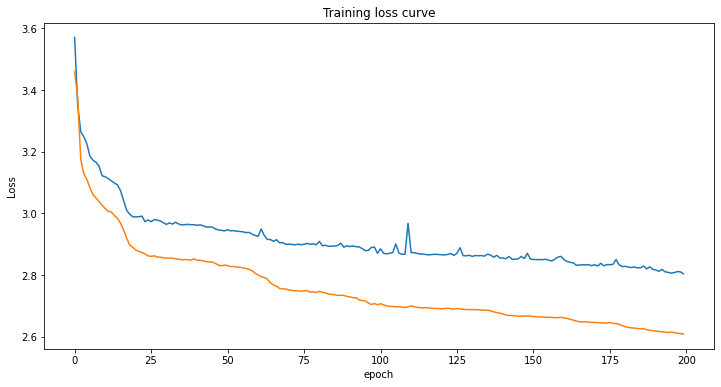

In [19]:
import matplotlib.pyplot as plt
# training_total_loss = [ i.detach().numpy() for i in training_all_loss]
plt.figure(figsize = (12,6))
plt.plot(range(len(validation_all_loss)),validation_all_loss)
plt.plot(range(len(training_all_loss)),training_all_loss)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title('Training loss curve')
plt.show()


In [20]:
# import matplotlib.pyplot as plt
# # validation_total_loss = [ i.detach().numpy() for i in validation_all_loss]
# plt.figure(figsize = (12,6))
# plt.plot(range(len(validation_all_loss)),validation_all_loss)
# plt.xlabel("epoch")
# plt.ylabel("Loss")
# plt.title('Validation loss curve')
# plt.show()

In [21]:

import torchvision.transforms as T

        
def calculate_metrics(model):

    cal_metrics=calculate()
    model.to(device)
#     print("here")
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        count=0
        for batch,labels in train_gen:
    #             print("here2")
            count+=1
            batch=batch.float().to(device)
#             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            predictions=model(batch)
            predicted_masks=torch.argmax(predictions,dim=1).type(torch.float)
            labels = labels.squeeze(1).to(device)
            cal_metrics.add(predicted_masks.cpu(),labels.cpu()) 
        print("Training set: miou,maccuracy,accuracy: ",cal_metrics.calculate_accuracy())

    cal_metrics_=calculate()
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        count=0
        for batch,labels in test_gen:
    #             print("here2")
            count+=1
            batch=batch.float().to(device)
#             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            predictions=model(batch)
            predicted_masks=torch.argmax(predictions,dim=1).type(torch.float)
            labels = labels.squeeze(1).to(device)
            cal_metrics_.add(predicted_masks.cpu(),labels.cpu()) 
        print("Testing set: miou,maccuracy,accuracy: ",cal_metrics_.calculate_accuracy())

calculate_metrics(model)

Training set: miou,maccuracy,accuracy:  (0.6596081586630923, 0.6596081586630923, 0.9194566817334505)
Testing set: miou,maccuracy,accuracy:  (0.5581989020909662, 0.5581989020909662, 0.8150119947350541)


In [27]:
import torchvision.transforms.functional as F

testing_total_loss=0
testing_loss=0
model.to(device)
model.eval()
print("here")
with torch.set_grad_enabled(False):
    print("here1")
    for batch,labels in test_gen:
#             print("here2")
        batch=batch.float().to(device)
        labels=labels.float()
#         labels = ((labels - labels.min()) * (1/(labels.max() - labels.min())*30))
#         print("batch size", batch.size())
#             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
#             print(batch,label)
        predictions=model(batch)
#             print("predictions" ,predictions)
#             print("predictions size",predictions.size())
#             print("norm_pred",norm_pred.size())
#         npred = torch.argmax(predictions.squeeze(),dim=1)
        predictions = predictions.type(torch.FloatTensor)
        npred = torch.nn.functional.softmax(predictions,dim =1).to(device)
        print("np ", npred.size())
        labels = labels.squeeze(1).to(device)

        pred_loss = lossfunc(npred,labels.long()) 
#         testing_loss.append(pred_loss)
        print("pred_loss",pred_loss)
#         print("batch[0]",batch[0])
        masks = [
            npred[img_idx,sem_class_to_idx[cls]]
            for img_idx in range(batch.shape[0])
            for cls in classes]
        break

here
here1
np  torch.Size([20, 31, 256, 256])
pred_loss tensor(2.6735, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


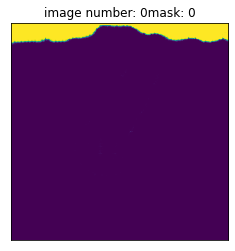

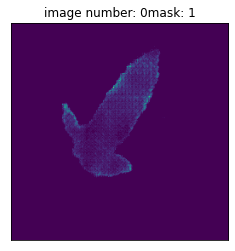

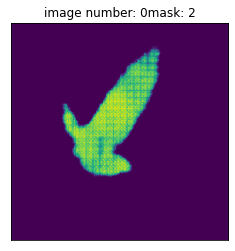

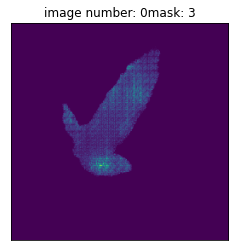

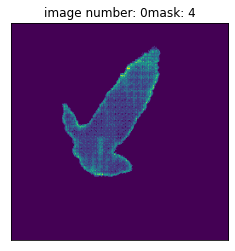

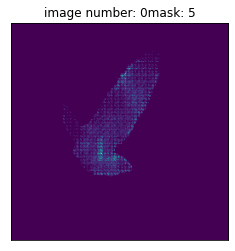

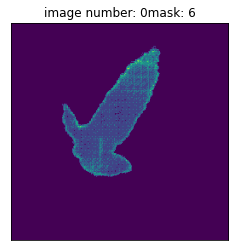

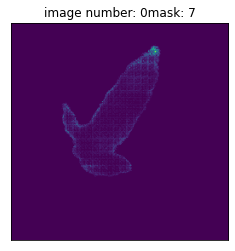

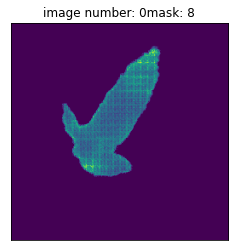

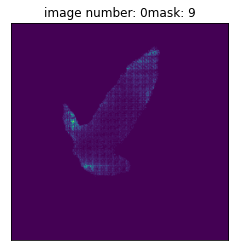

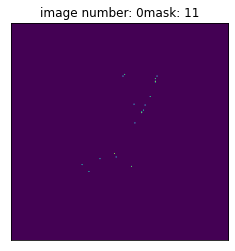

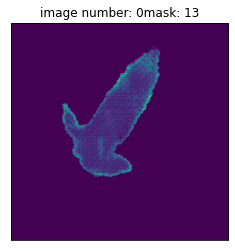

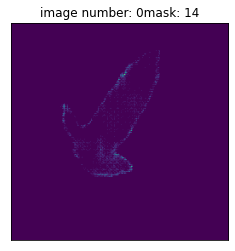

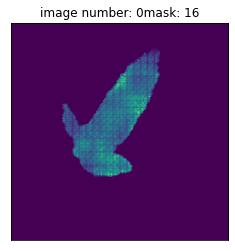

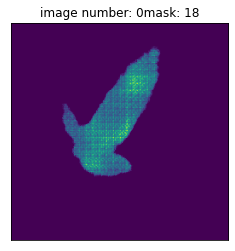

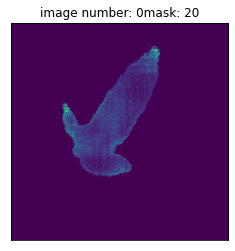

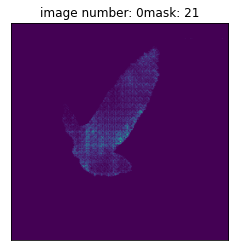

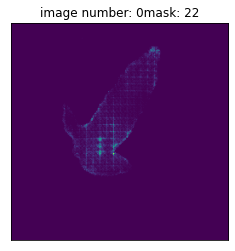

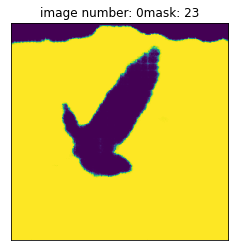

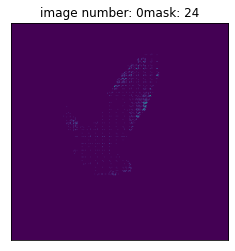

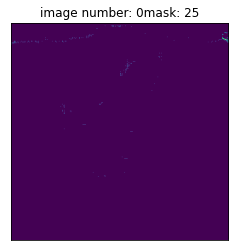

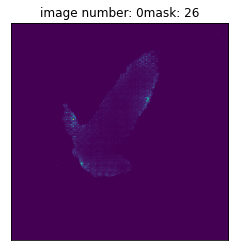

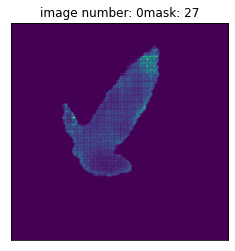

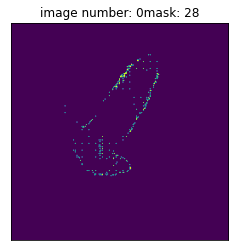

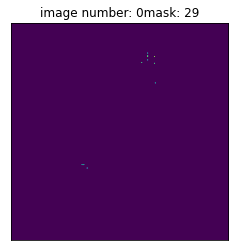

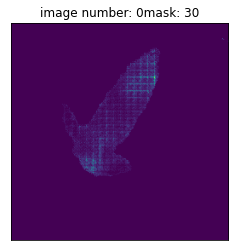

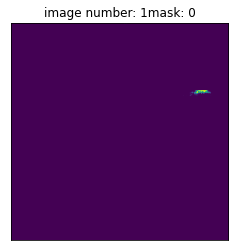

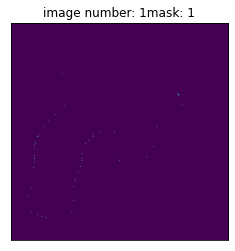

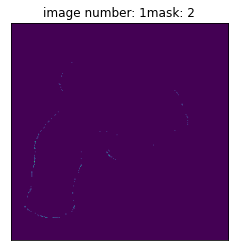

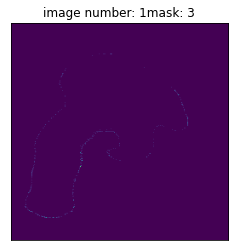

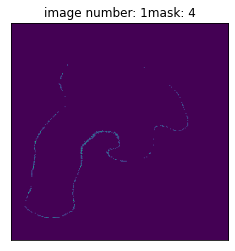

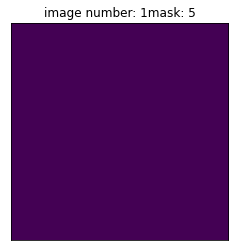

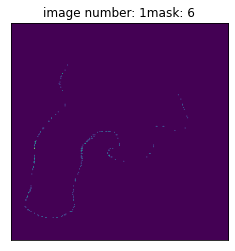

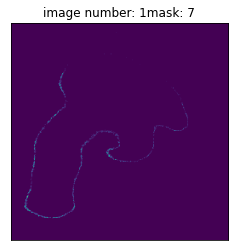

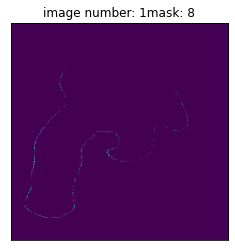

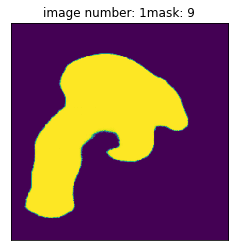

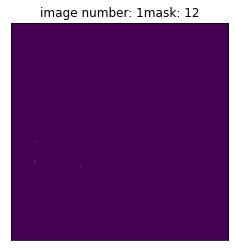

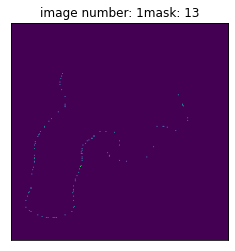

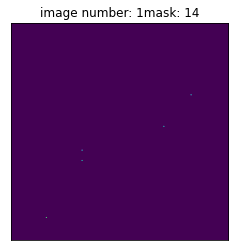

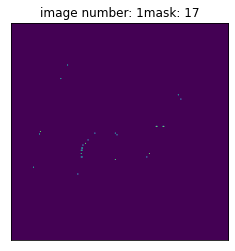

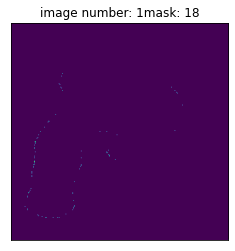

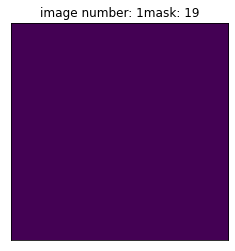

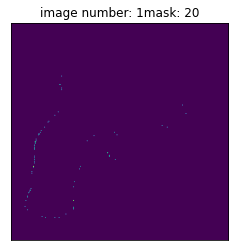

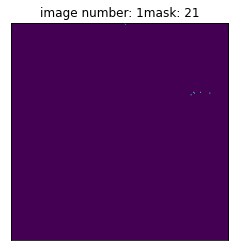

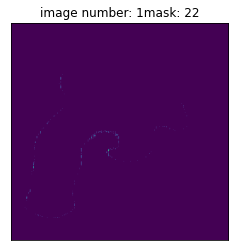

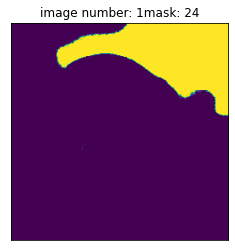

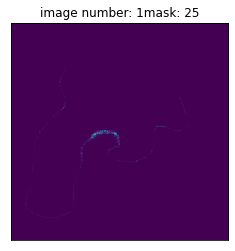

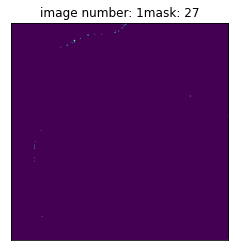

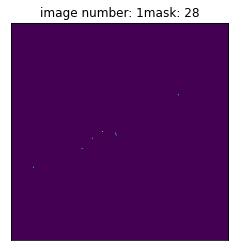

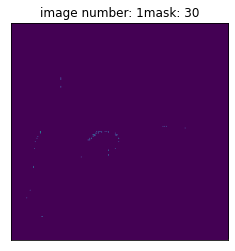

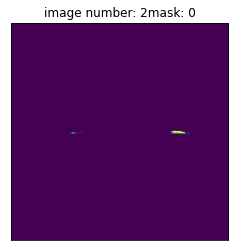

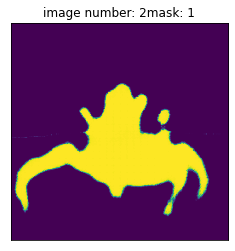

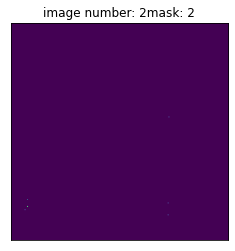

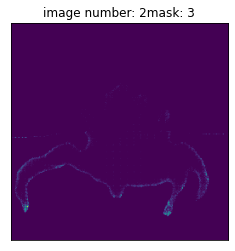

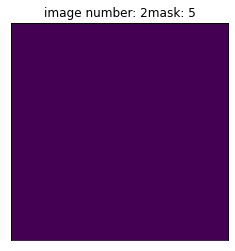

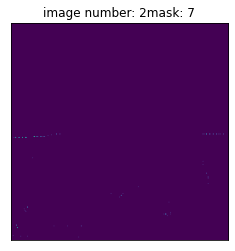

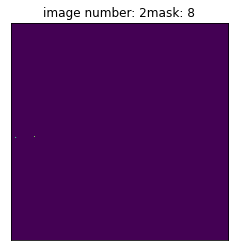

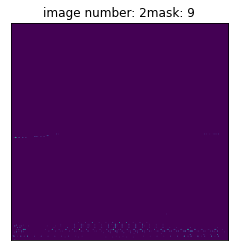

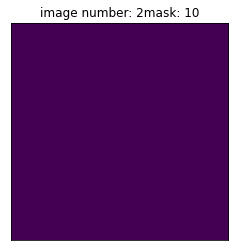

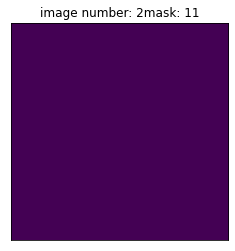

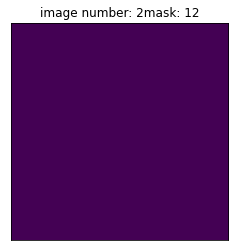

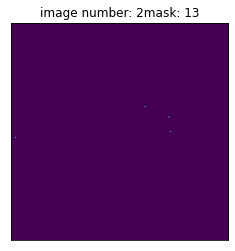

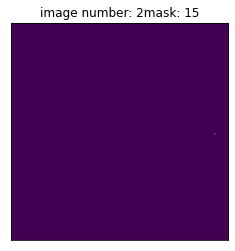

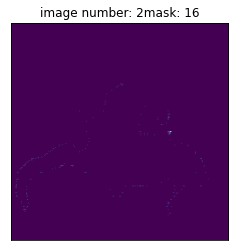

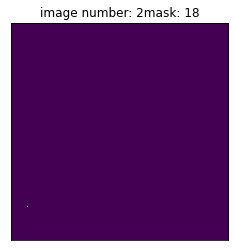

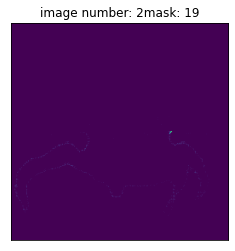

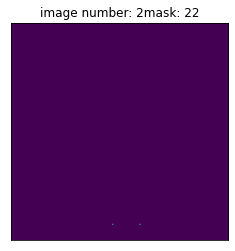

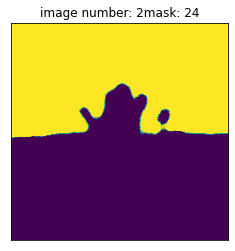

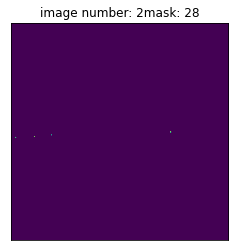

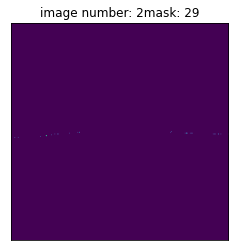

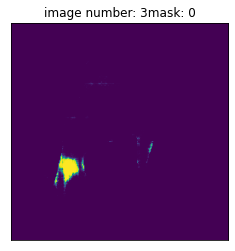

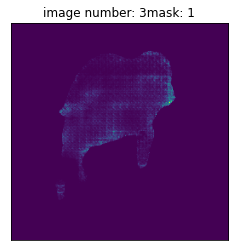

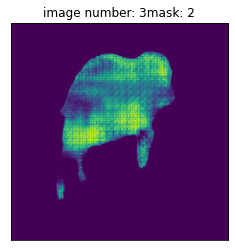

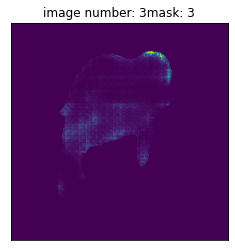

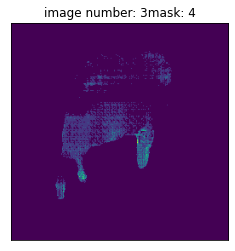

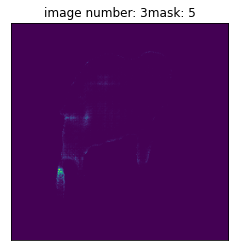

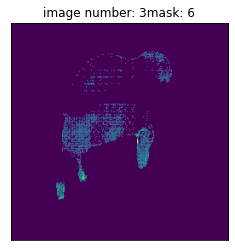

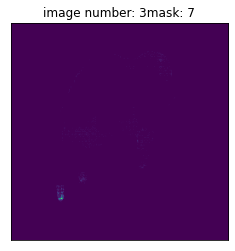

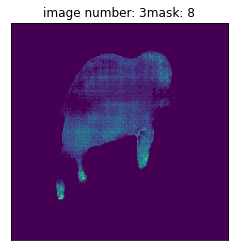

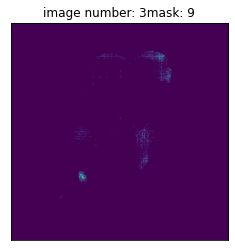

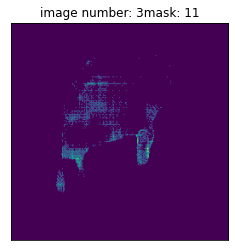

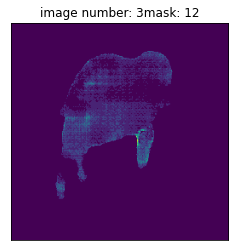

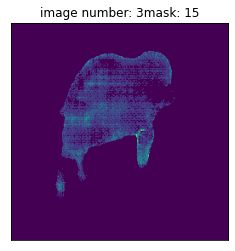

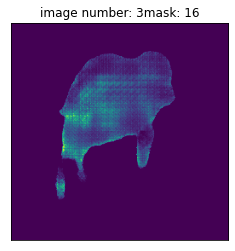

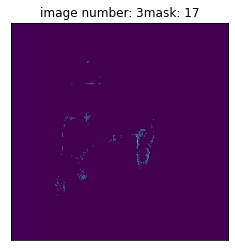

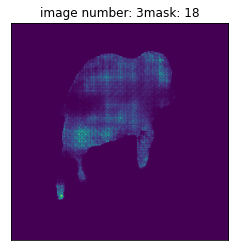

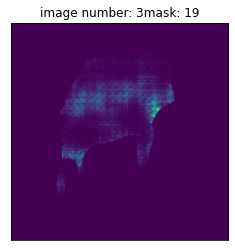

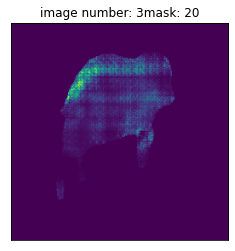

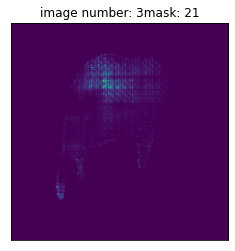

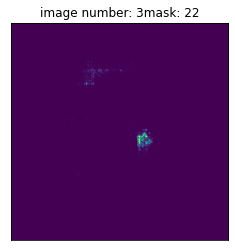

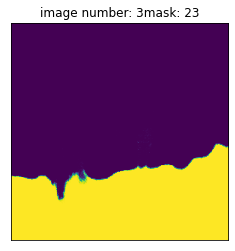

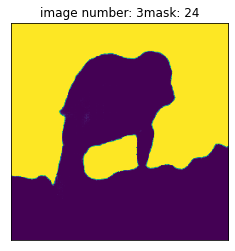

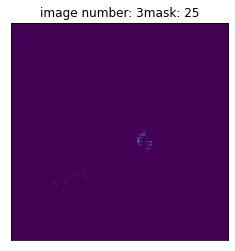

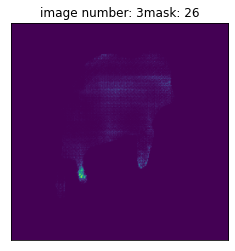

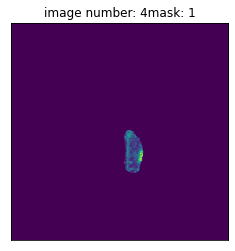

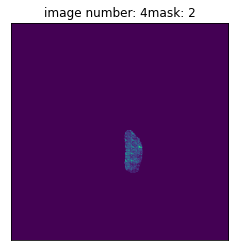

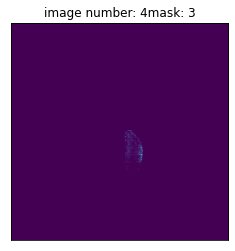

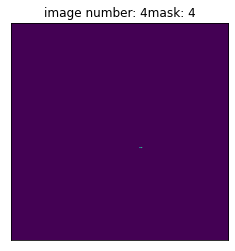

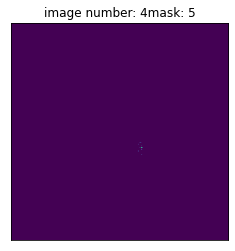

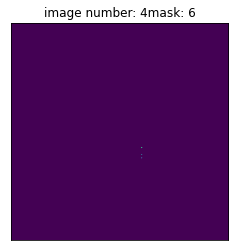

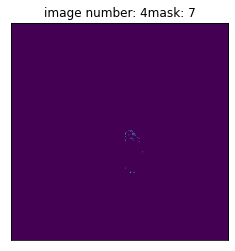

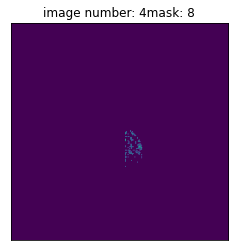

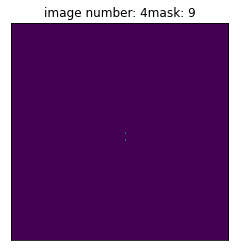

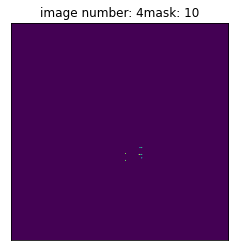

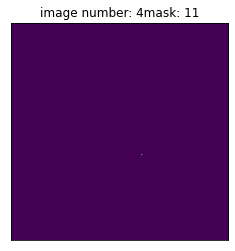

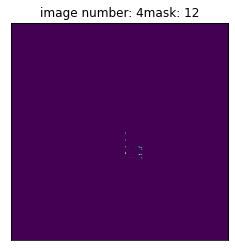

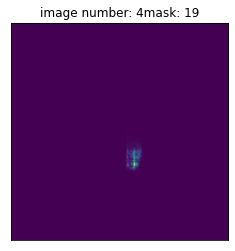

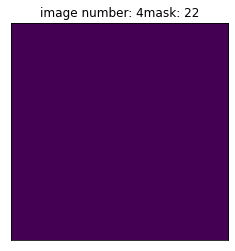

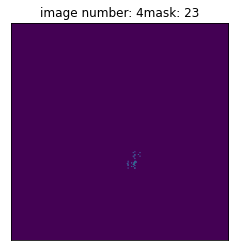

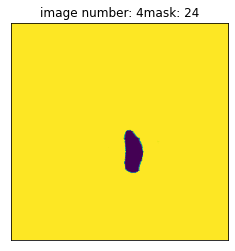

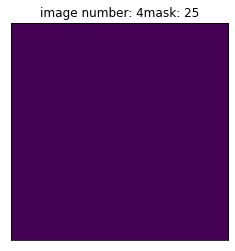

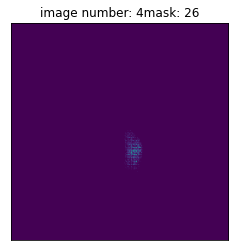

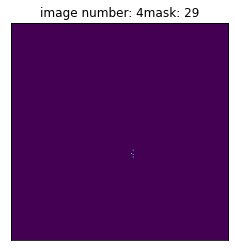

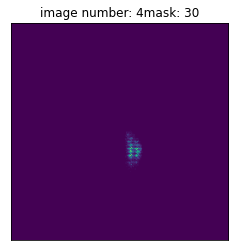

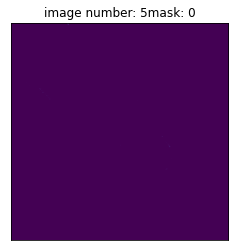

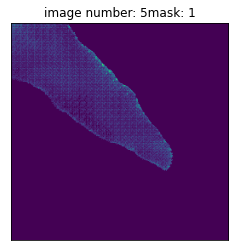

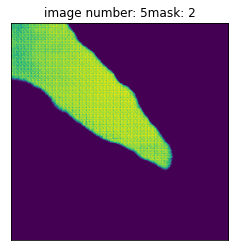

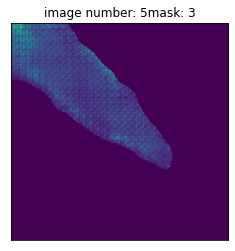

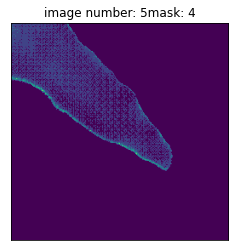

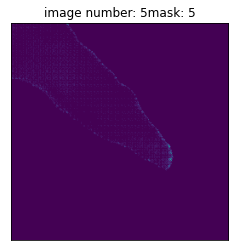

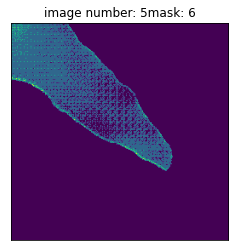

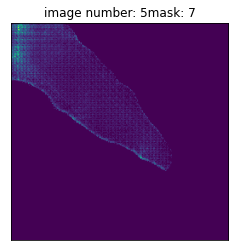

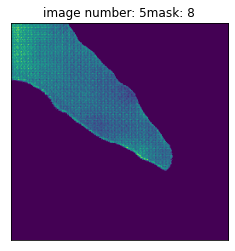

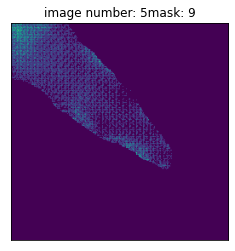

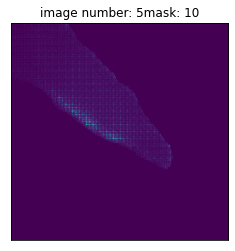

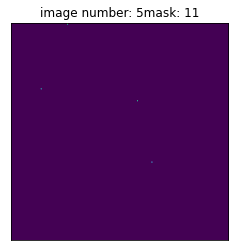

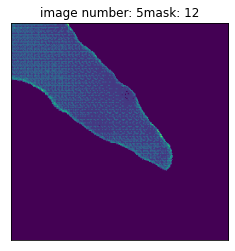

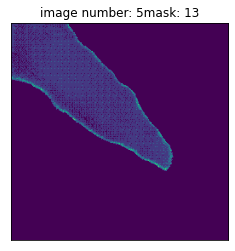

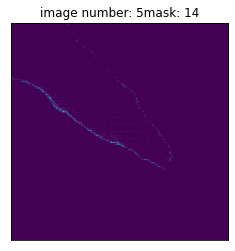

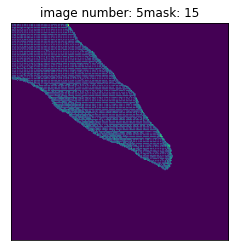

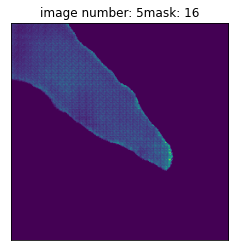

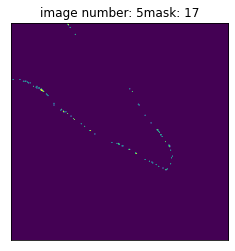

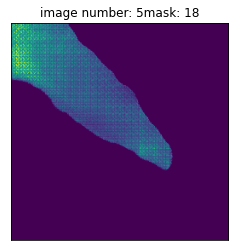

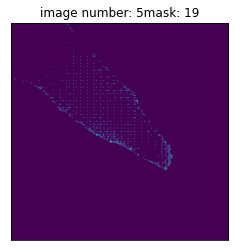

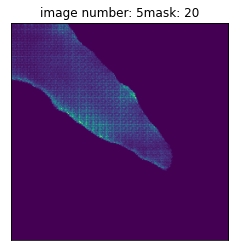

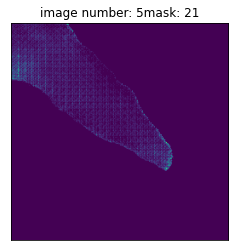

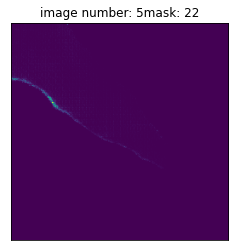

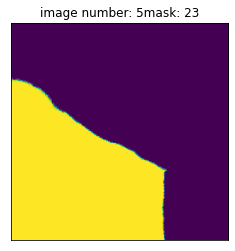

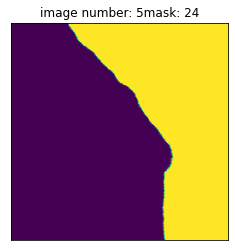

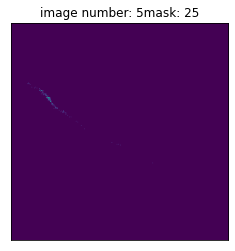

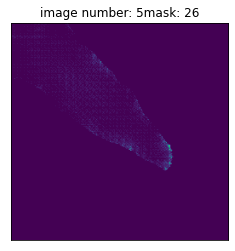

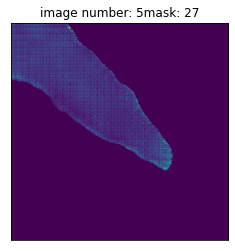

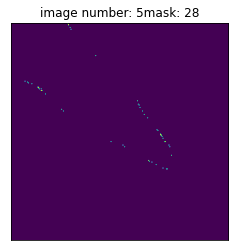

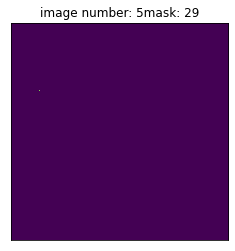

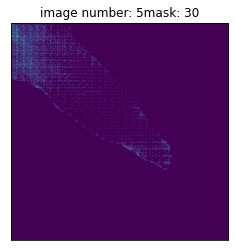

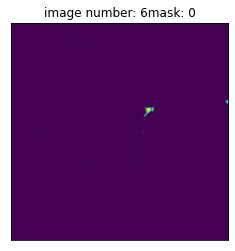

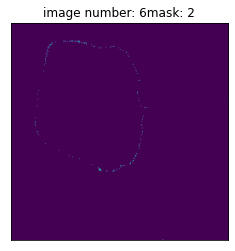

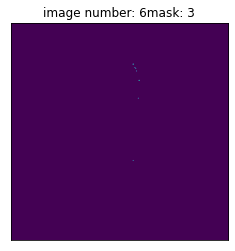

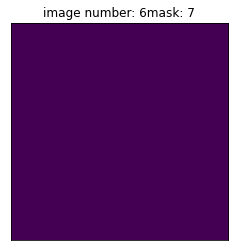

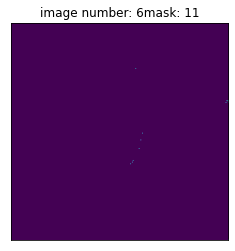

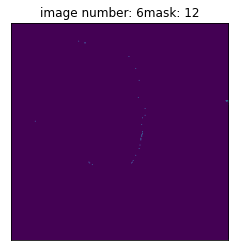

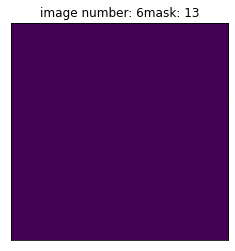

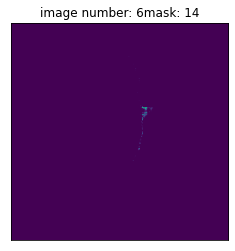

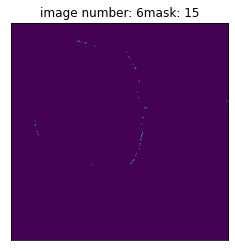

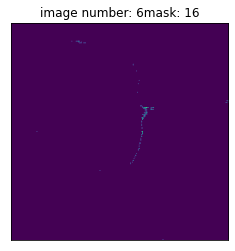

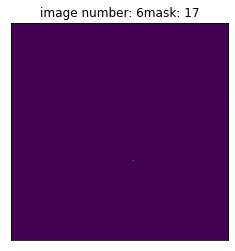

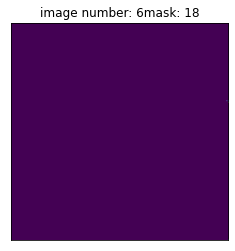

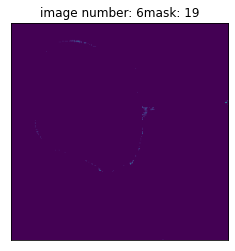

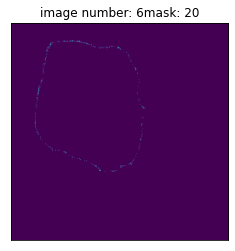

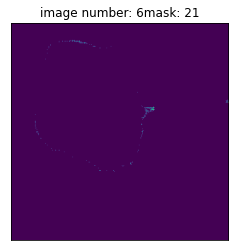

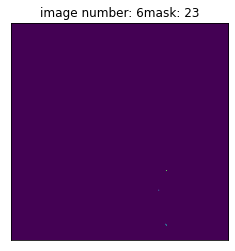

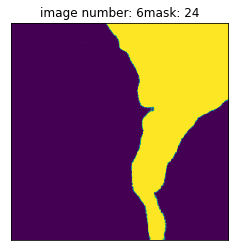

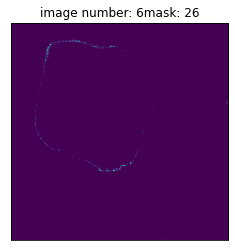

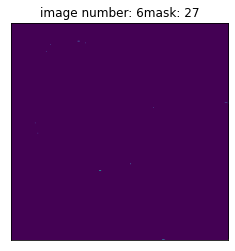

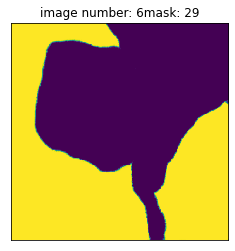

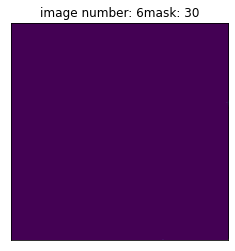

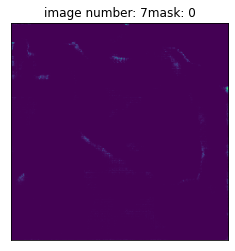

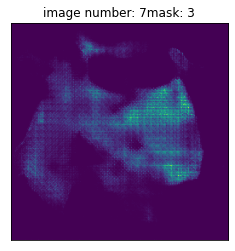

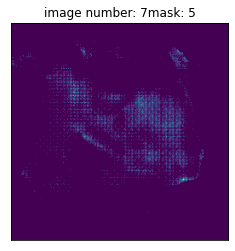

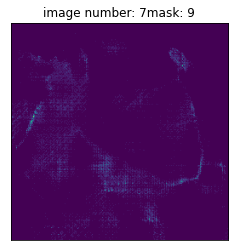

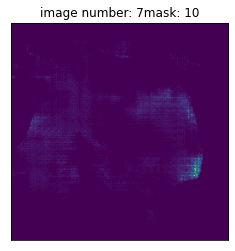

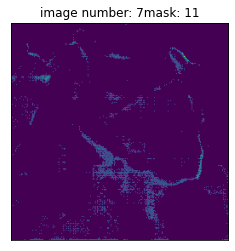

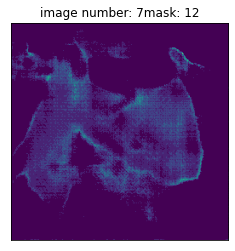

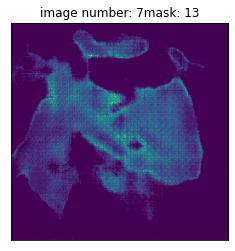

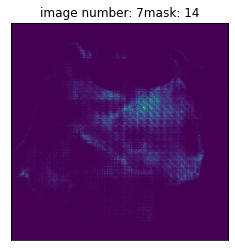

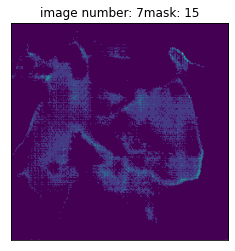

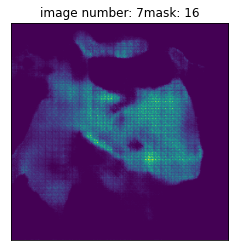

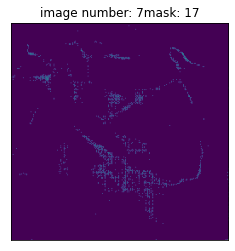

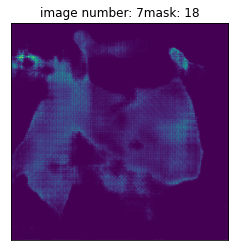

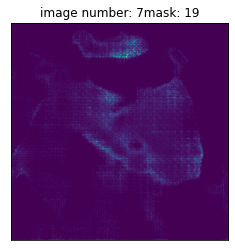

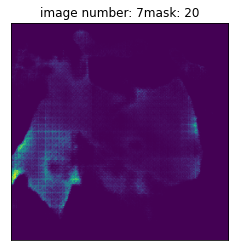

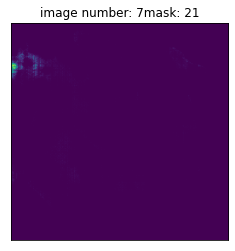

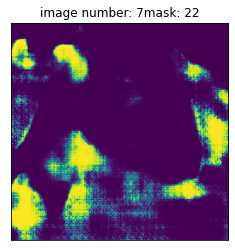

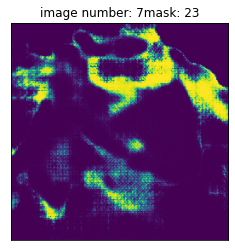

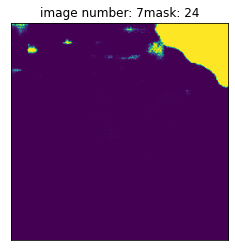

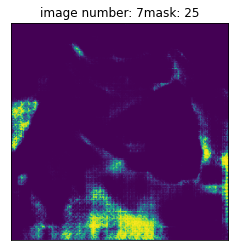

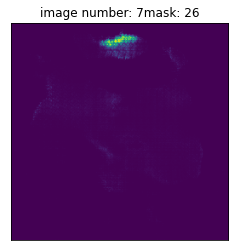

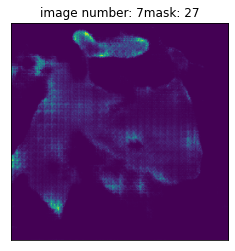

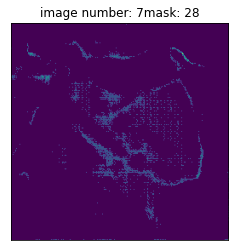

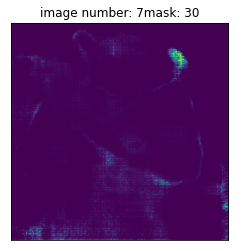

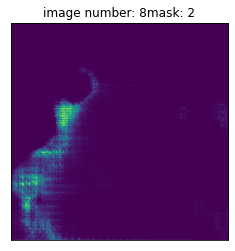

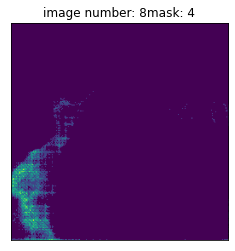

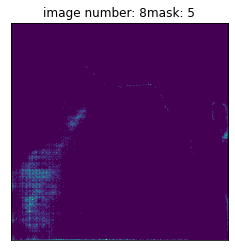

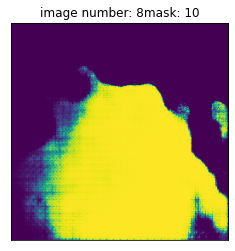

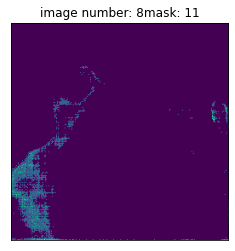

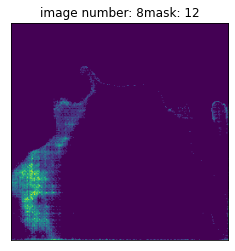

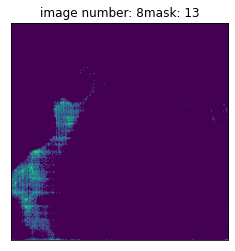

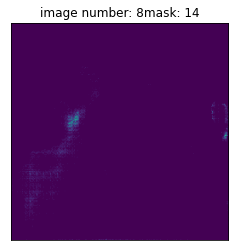

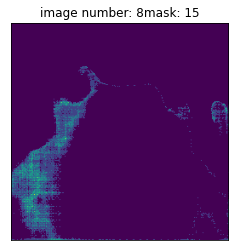

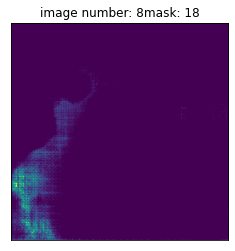

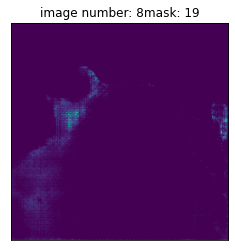

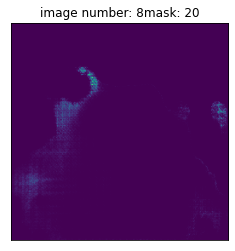

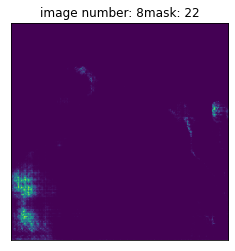

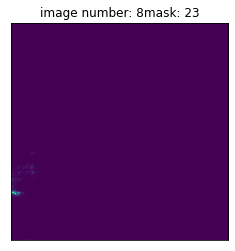

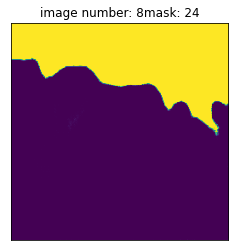

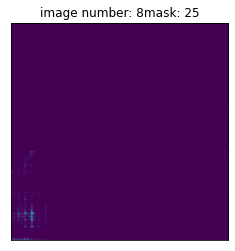

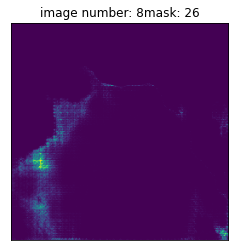

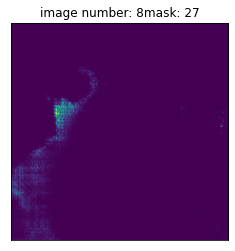

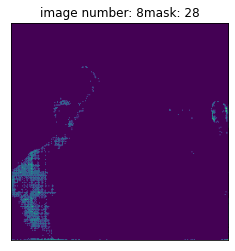

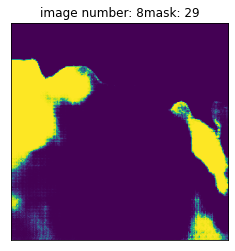

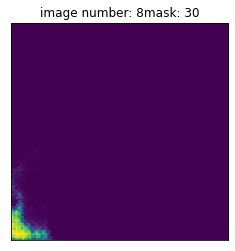

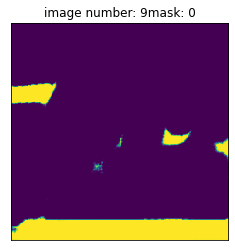

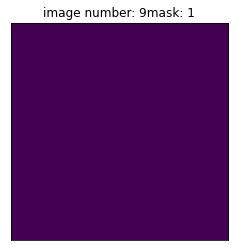

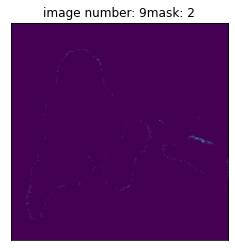

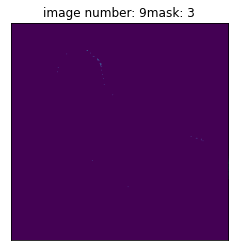

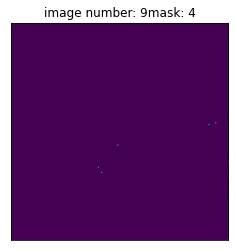

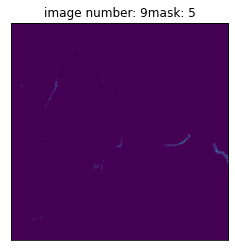

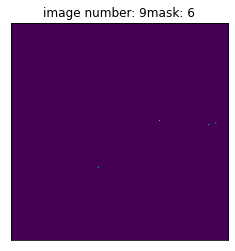

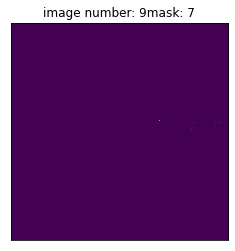

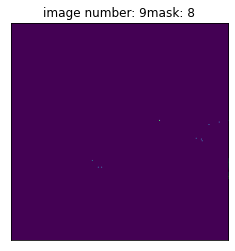

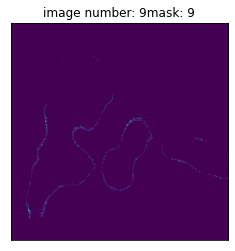

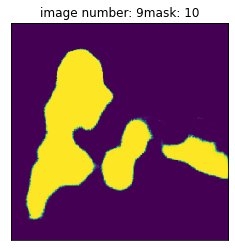

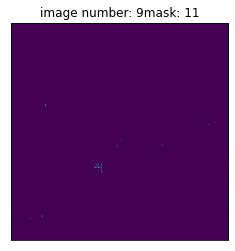

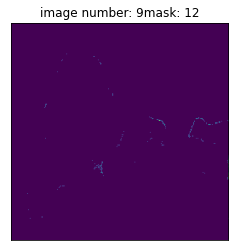

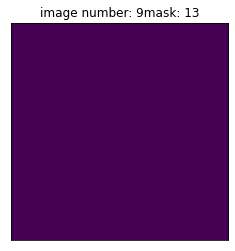

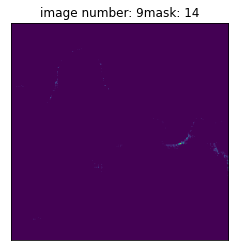

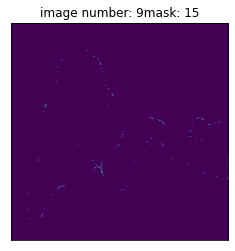

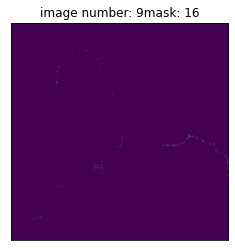

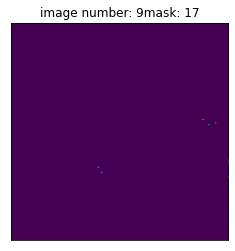

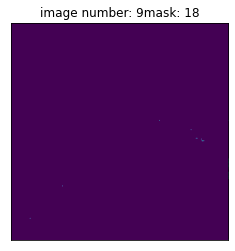

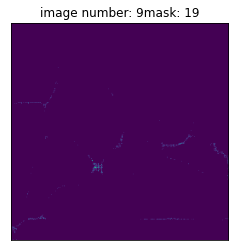

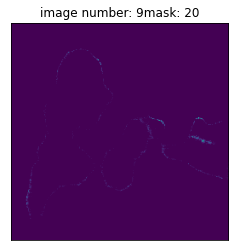

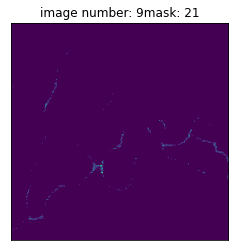

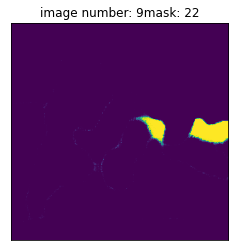

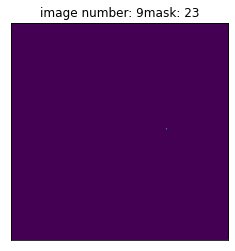

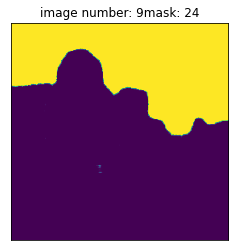

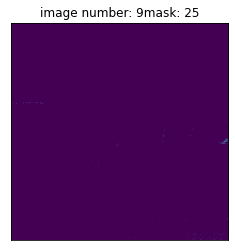

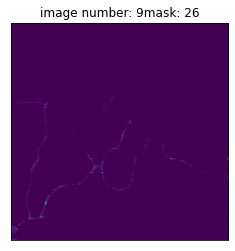

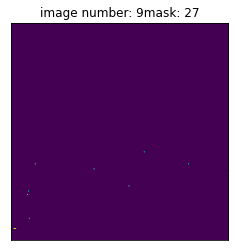

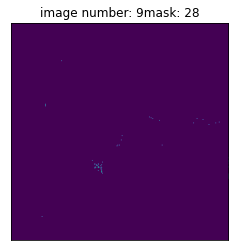

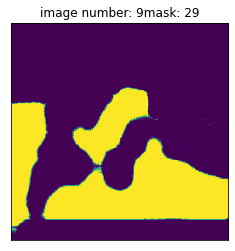

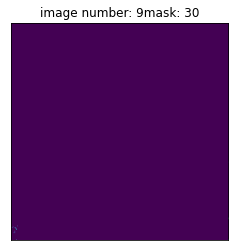

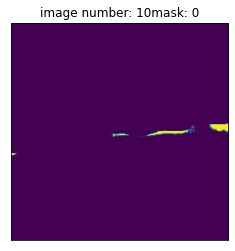

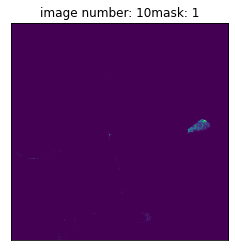

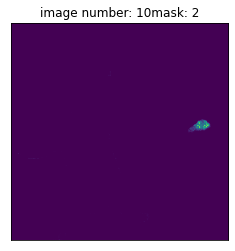

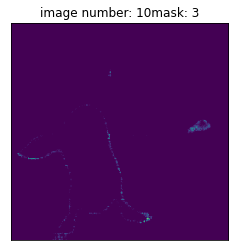

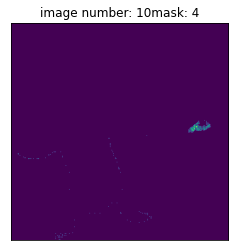

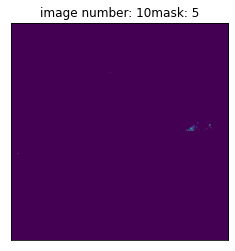

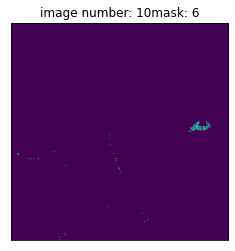

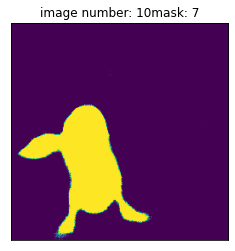

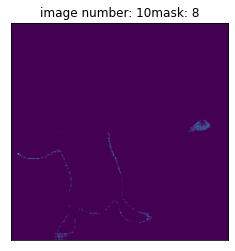

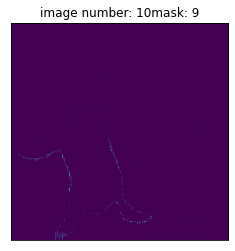

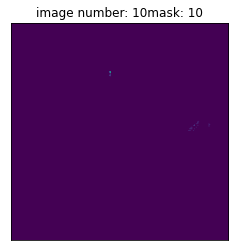

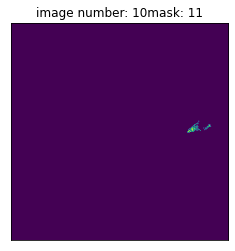

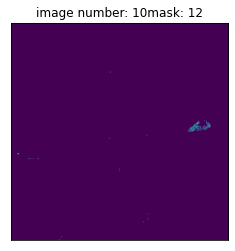

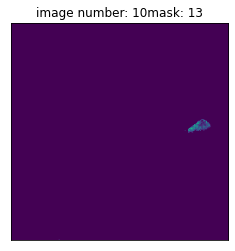

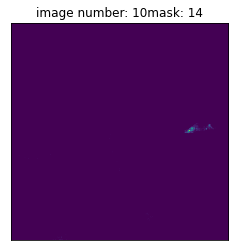

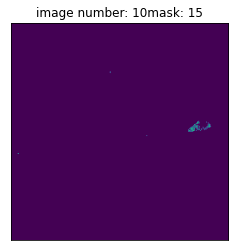

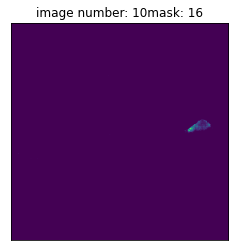

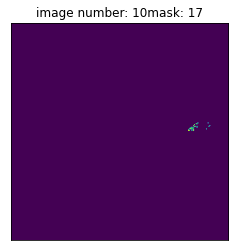

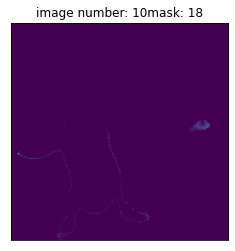

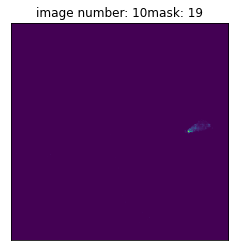

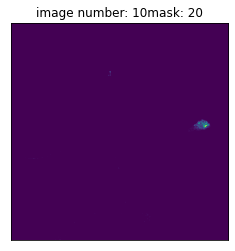

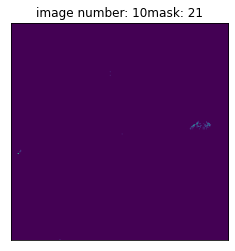

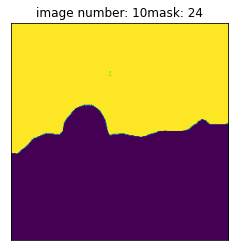

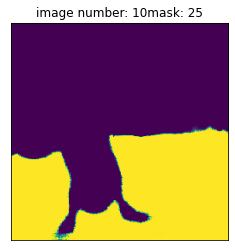

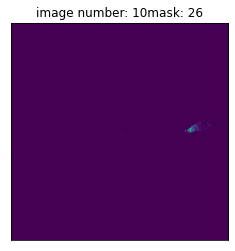

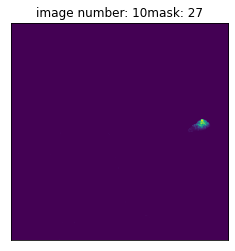

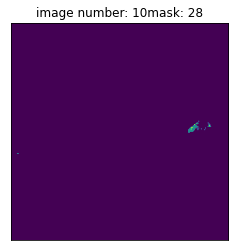

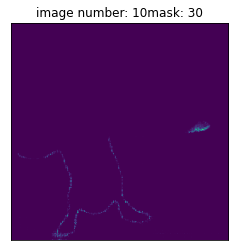

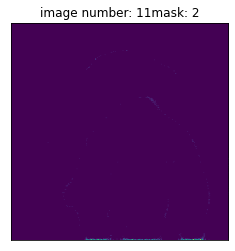

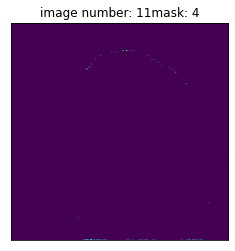

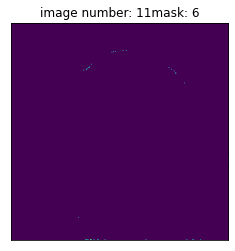

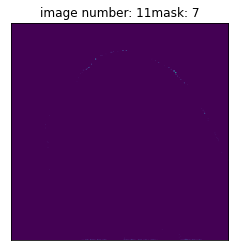

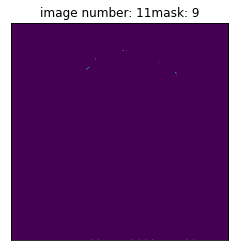

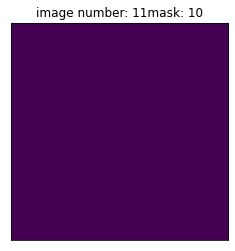

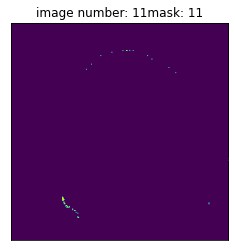

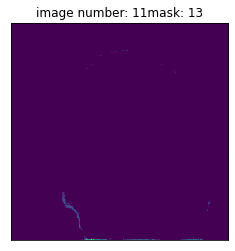

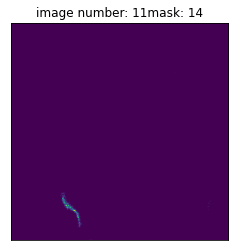

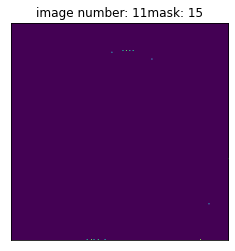

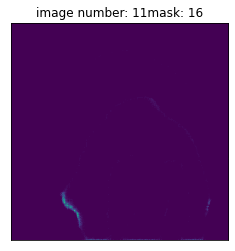

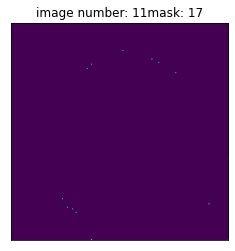

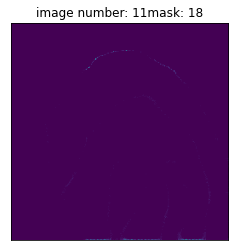

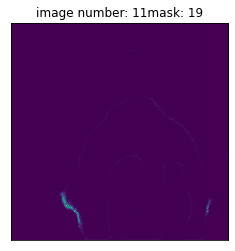

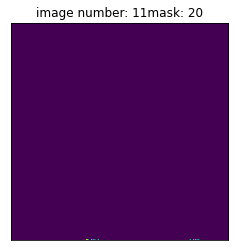

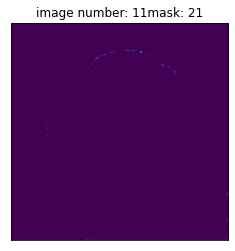

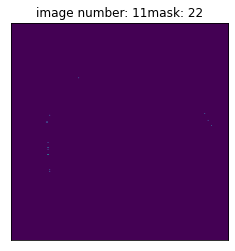

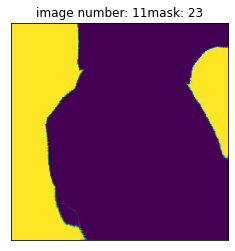

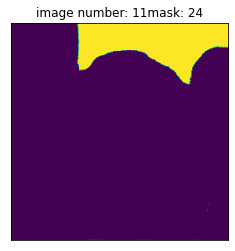

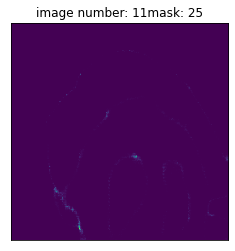

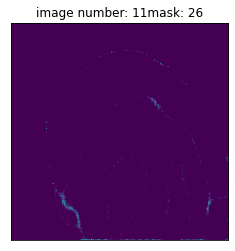

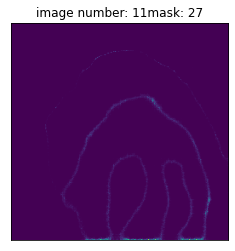

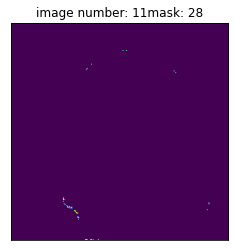

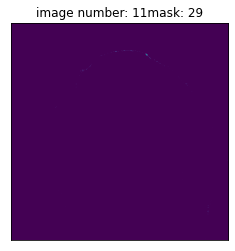

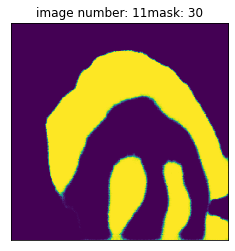

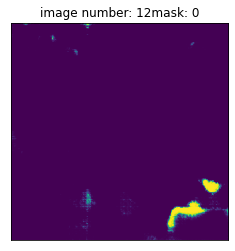

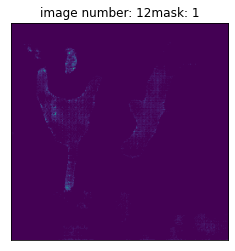

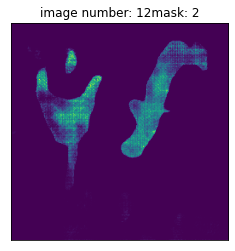

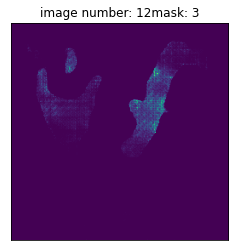

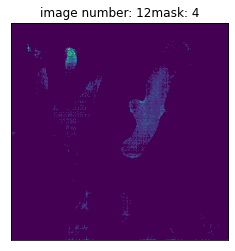

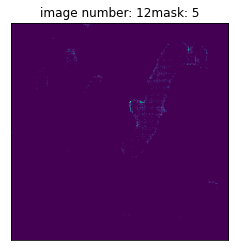

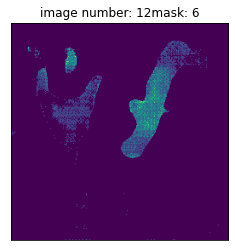

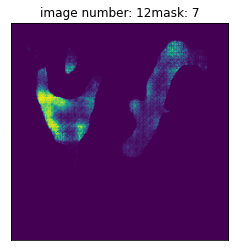

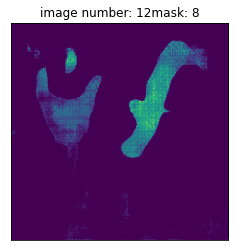

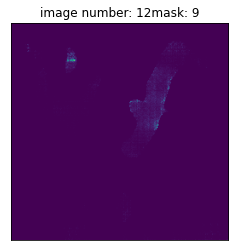

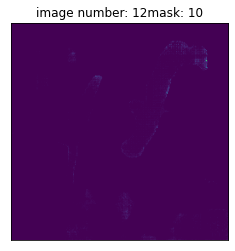

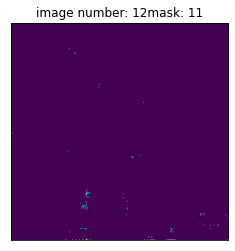

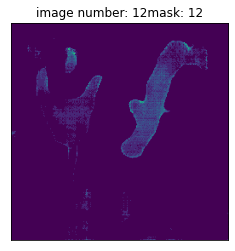

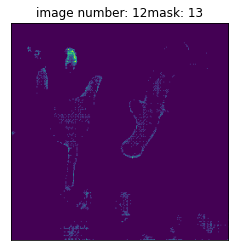

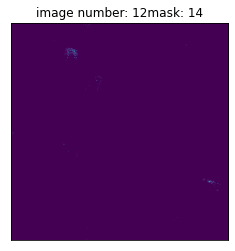

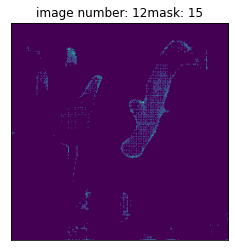

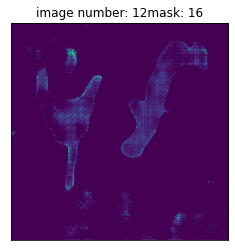

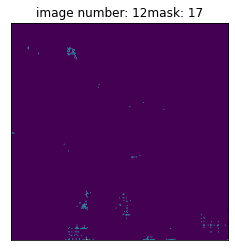

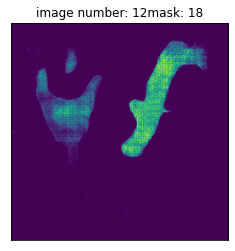

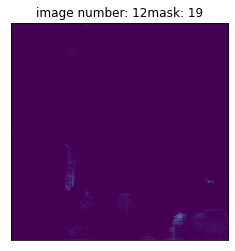

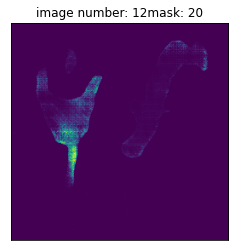

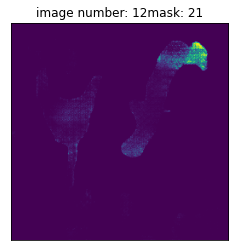

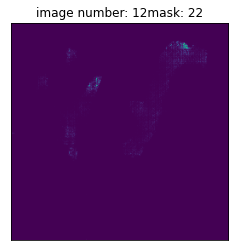

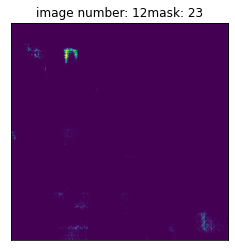

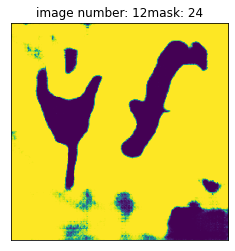

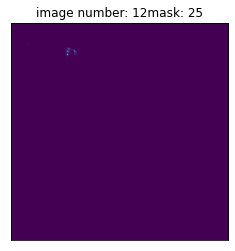

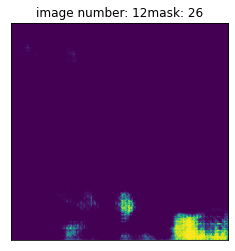

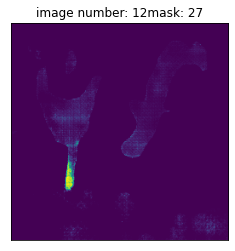

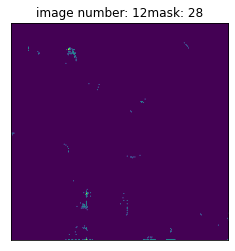

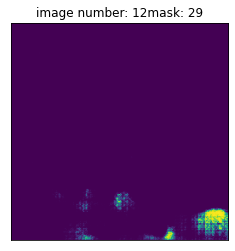

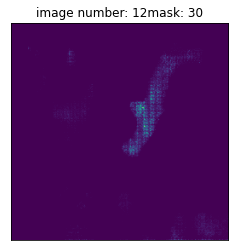

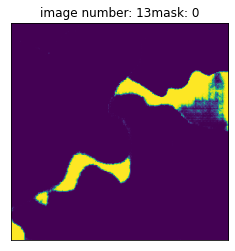

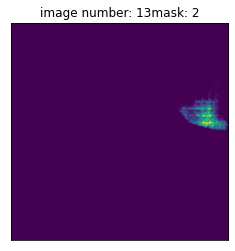

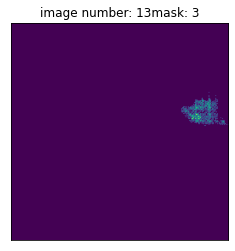

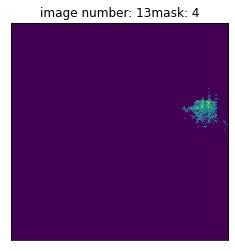

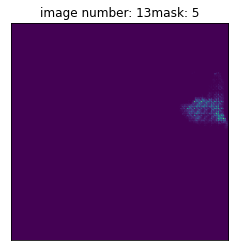

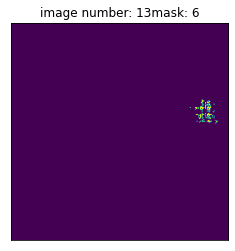

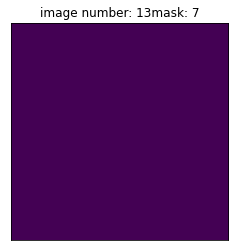

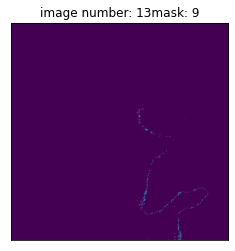

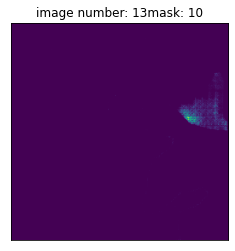

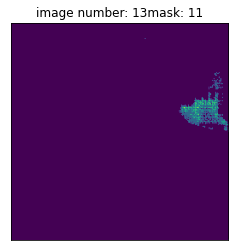

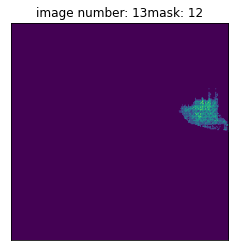

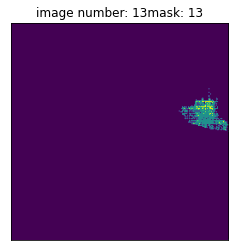

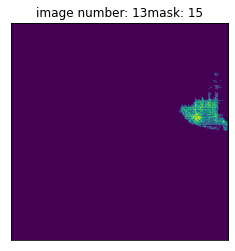

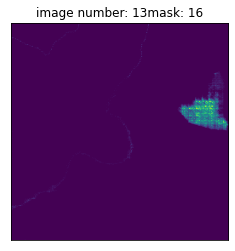

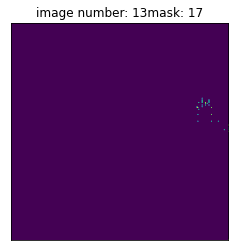

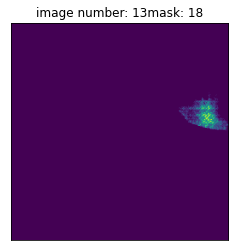

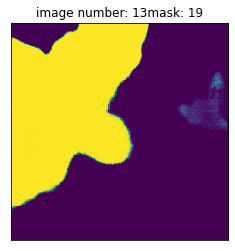

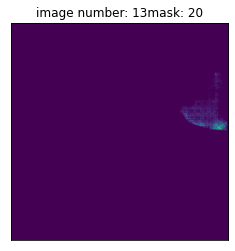

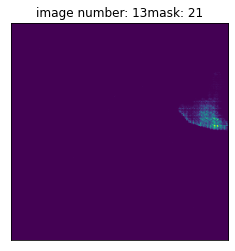

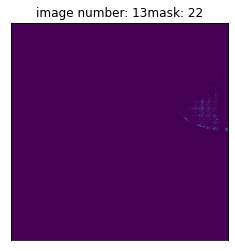

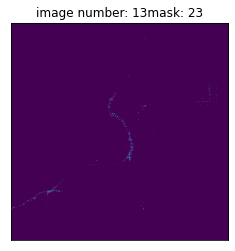

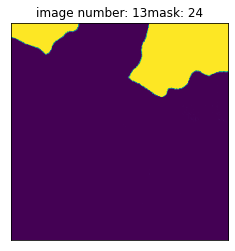

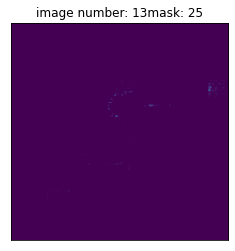

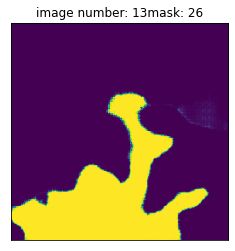

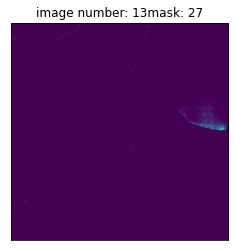

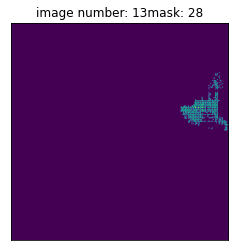

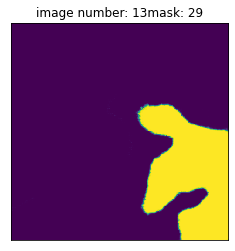

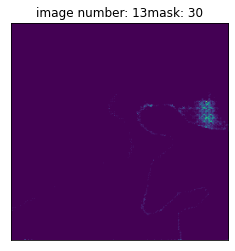

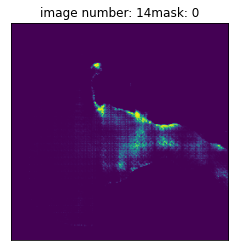

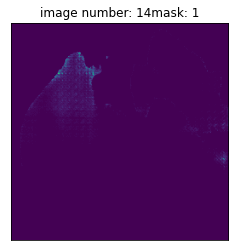

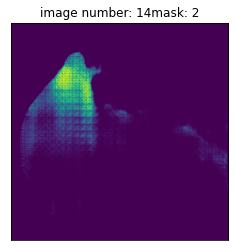

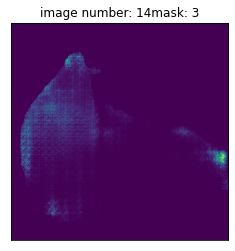

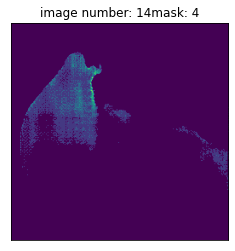

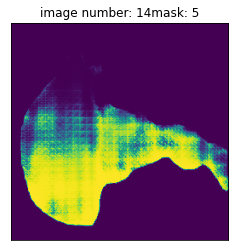

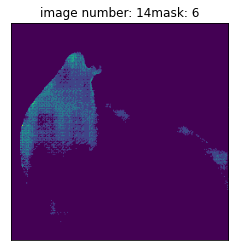

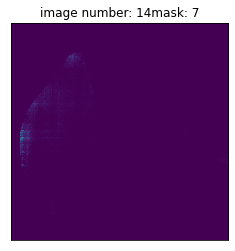

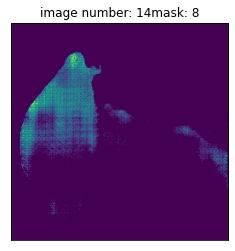

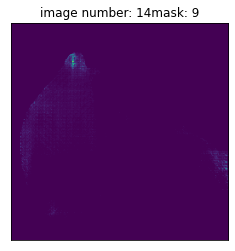

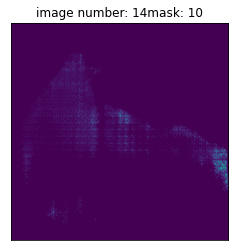

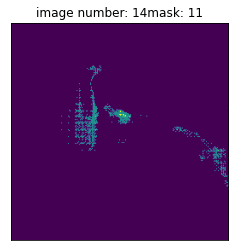

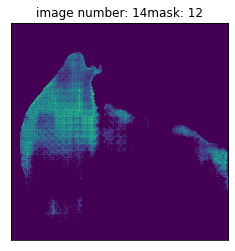

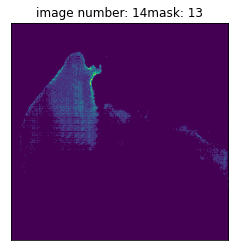

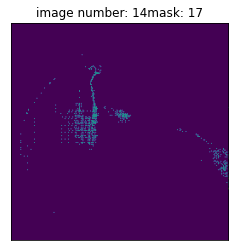

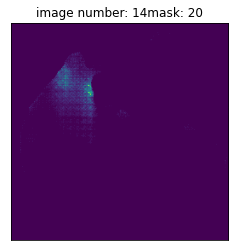

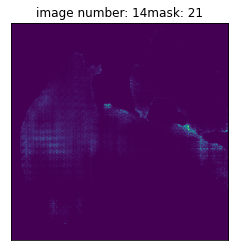

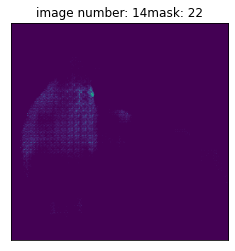

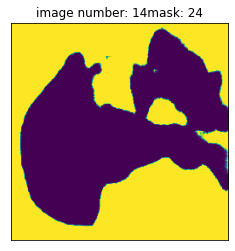

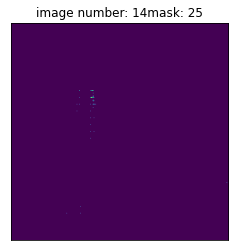

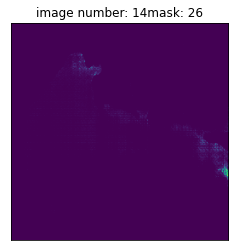

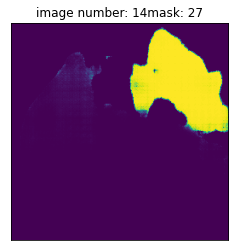

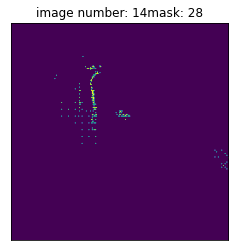

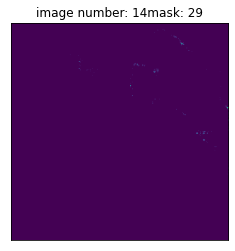

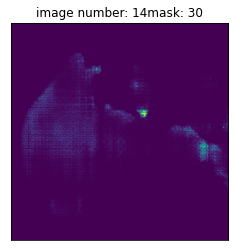

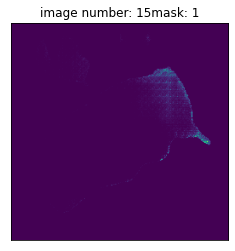

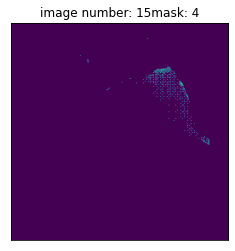

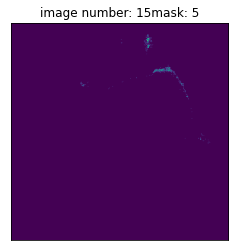

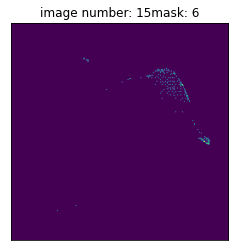

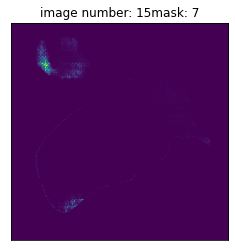

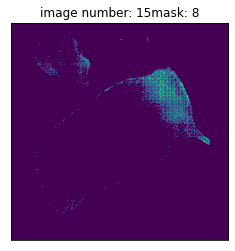

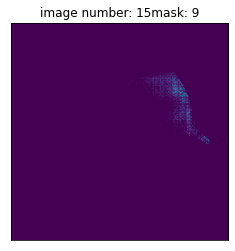

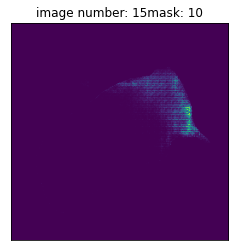

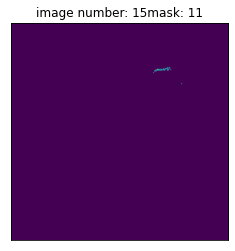

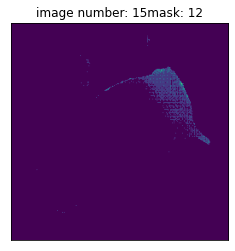

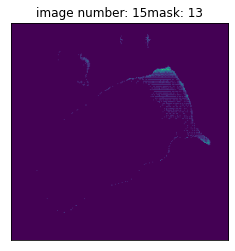

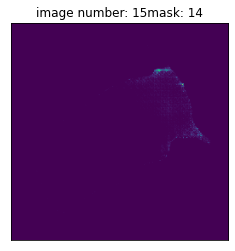

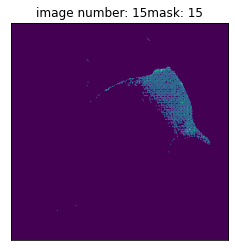

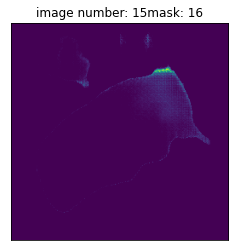

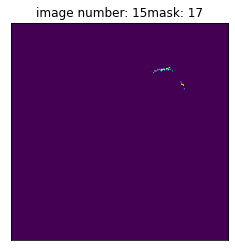

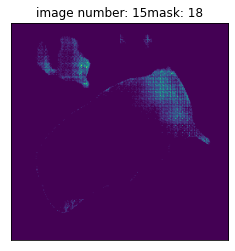

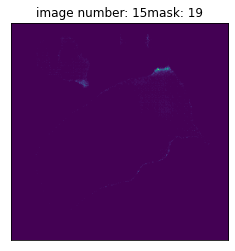

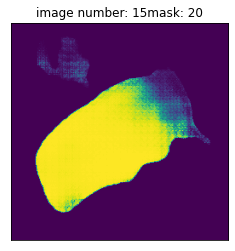

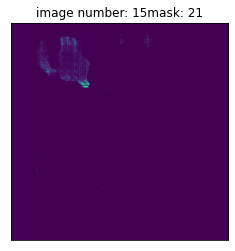

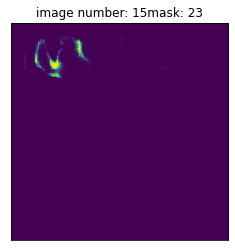

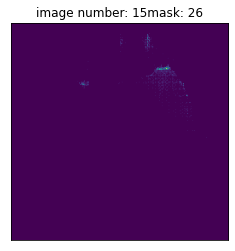

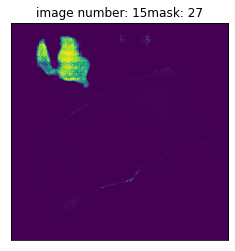

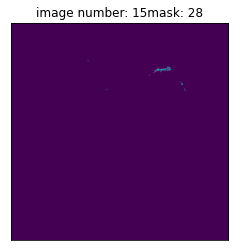

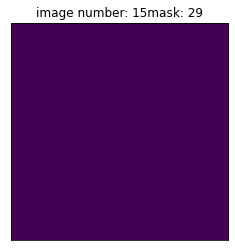

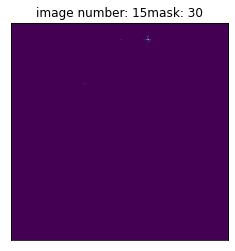

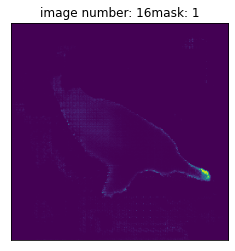

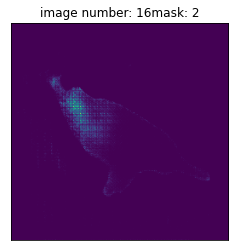

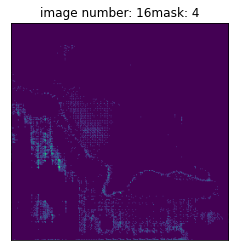

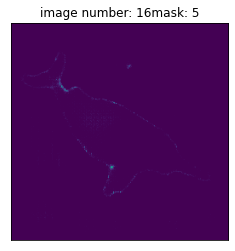

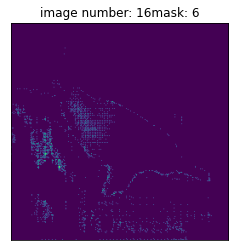

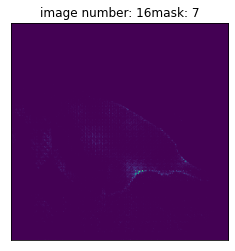

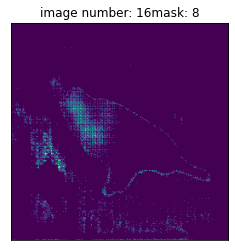

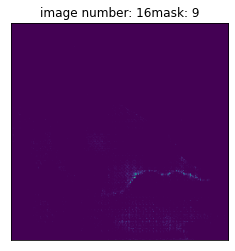

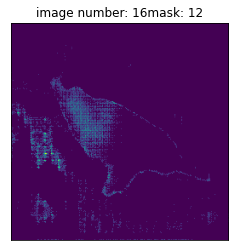

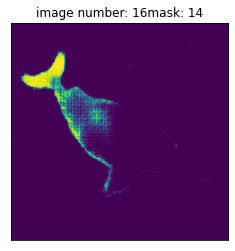

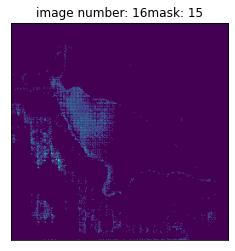

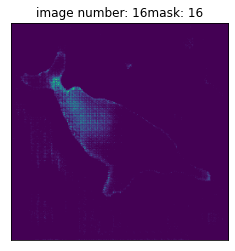

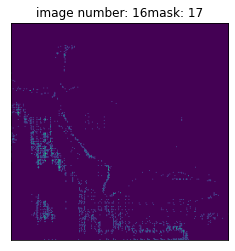

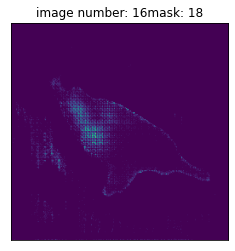

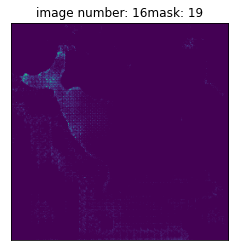

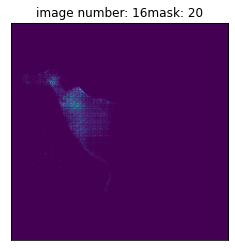

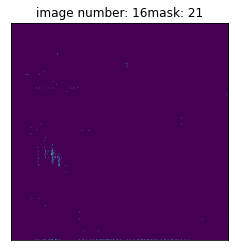

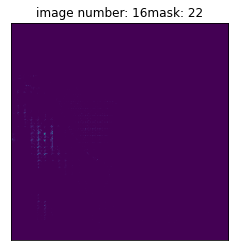

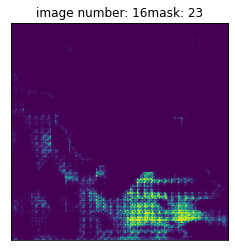

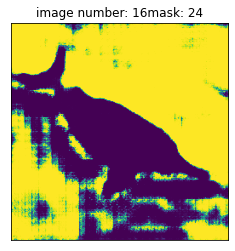

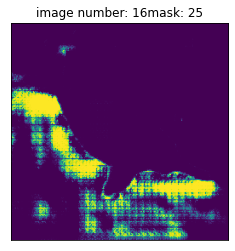

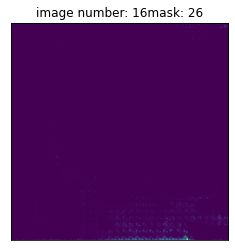

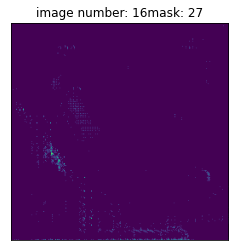

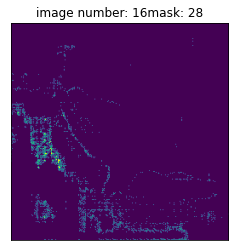

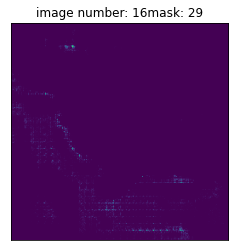

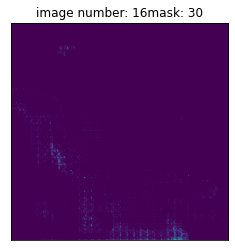

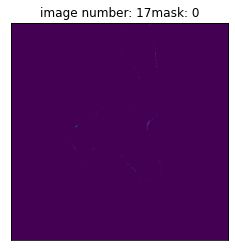

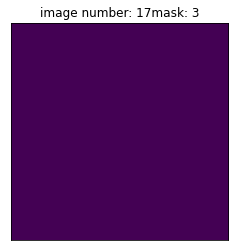

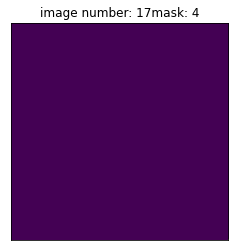

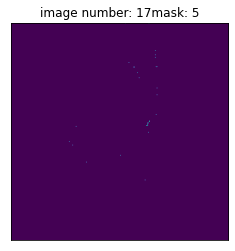

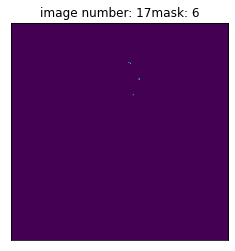

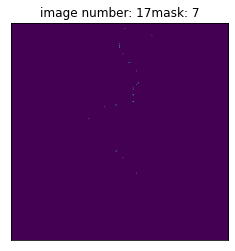

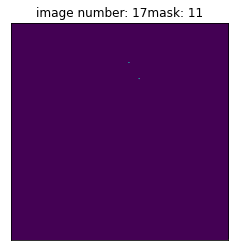

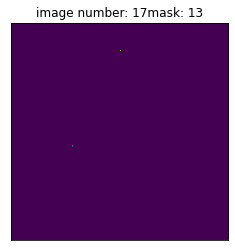

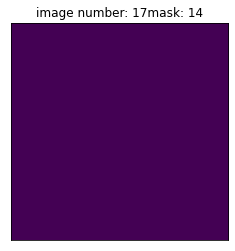

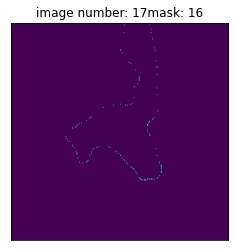

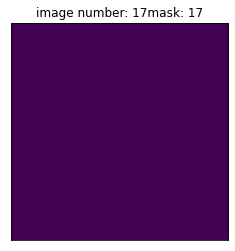

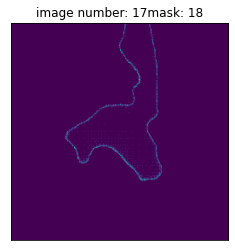

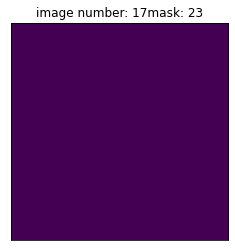

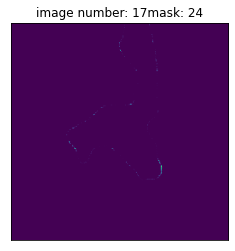

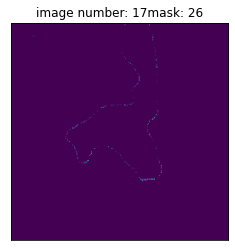

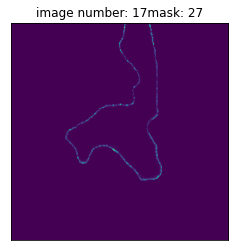

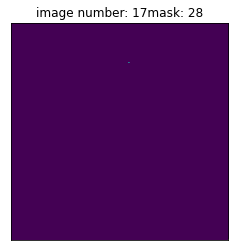

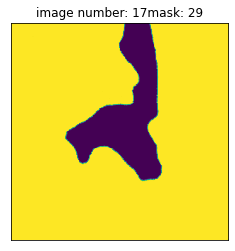

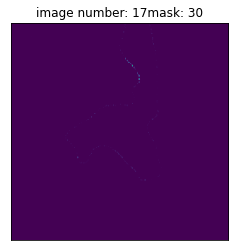

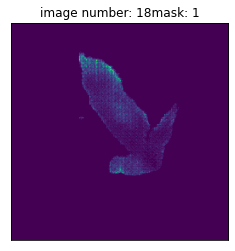

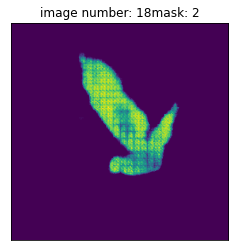

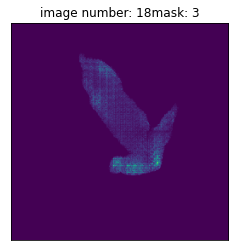

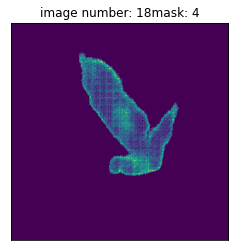

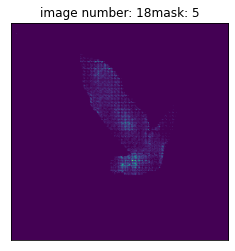

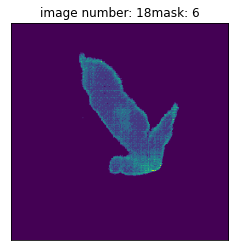

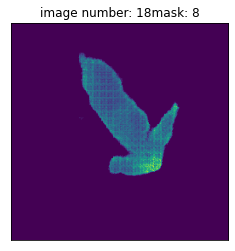

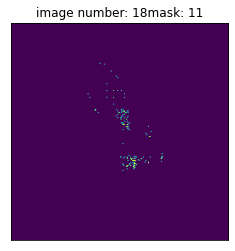

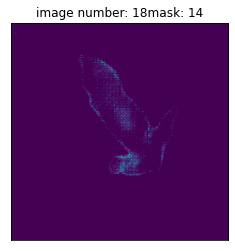

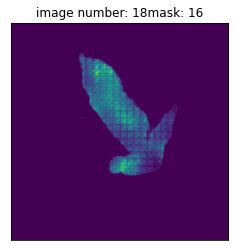

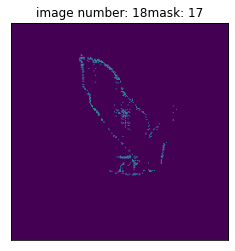

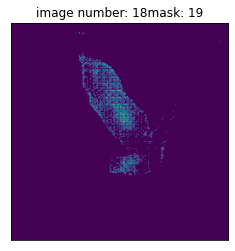

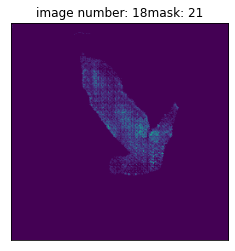

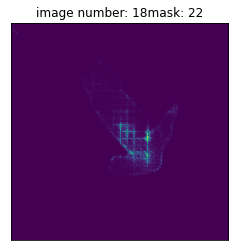

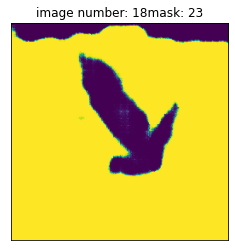

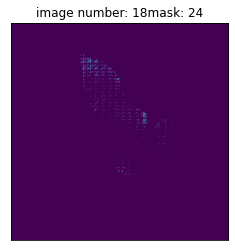

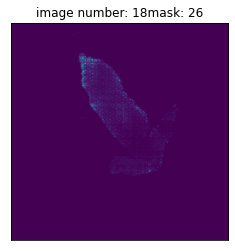

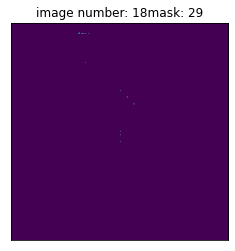

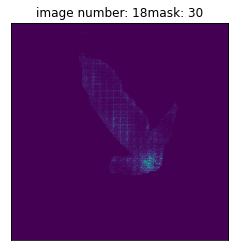

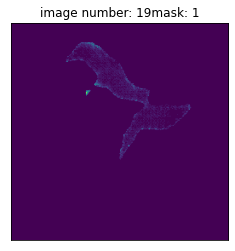

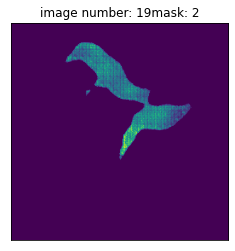

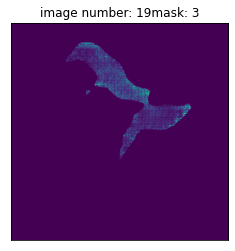

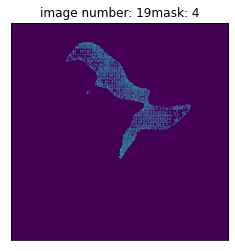

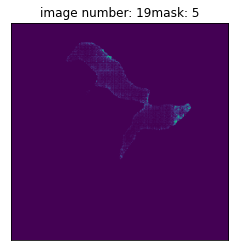

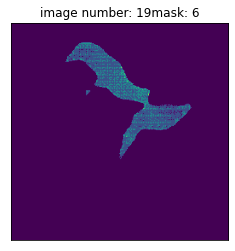

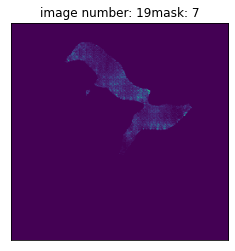

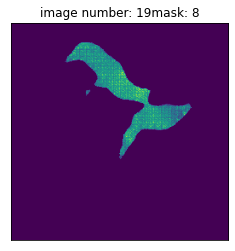

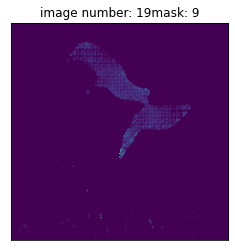

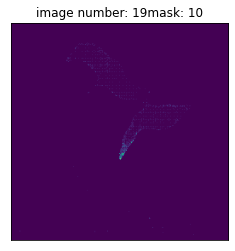

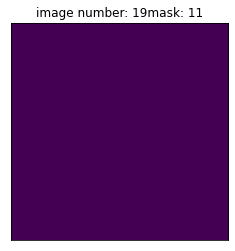

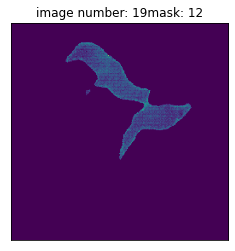

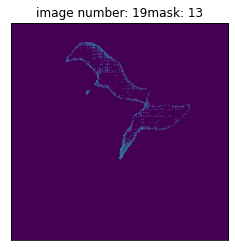

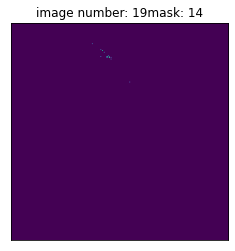

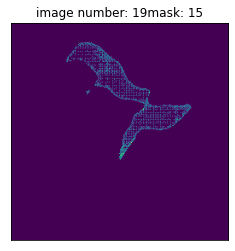

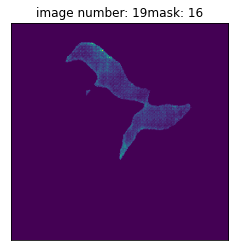

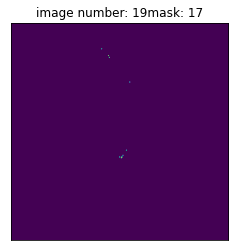

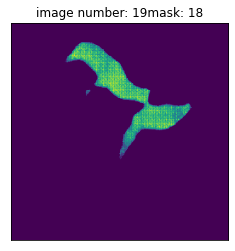

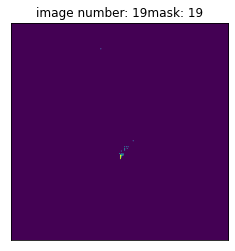

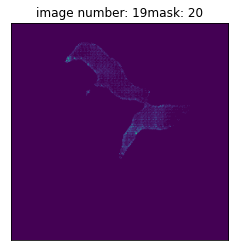

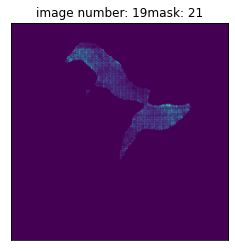

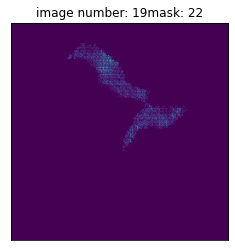

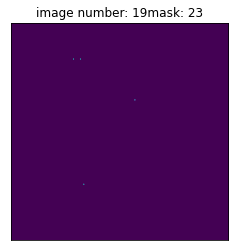

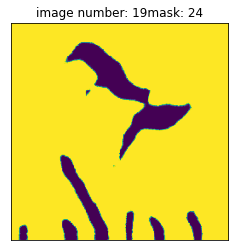

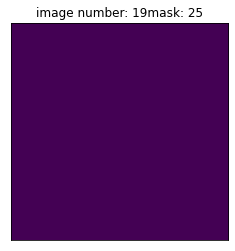

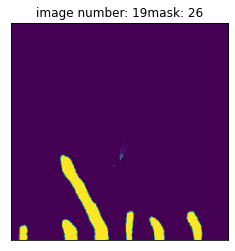

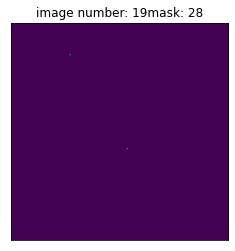

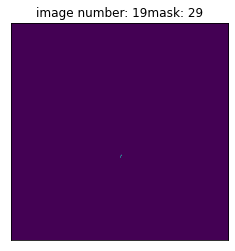

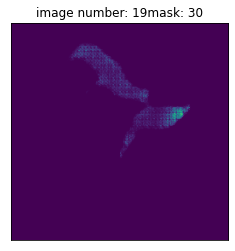

In [28]:

import matplotlib.pyplot as plt
def show(imgs,Image_number,number):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0,i].set_title("image number: "+str(Image_number)+"mask: "+str(number))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
Image_num = 0
num = 0        
for mask in masks:
    if num>30:
        num = 0
        Image_num +=1
#     print(i)
    show(mask,Image_num,num)
    num+=1
    
# show(masks)

In [ ]:
# from PIL import Image
# import torchvision.transforms as T
# transform = T.ToPILImage(mode = np.dtype(float))
# img = npred
# # img = torch.argmax(npred.squeeze(),dim=1)
# print(img.size())
# print(img[0].max())
# image = transform(img[0])
# new_im = ((npred - npred.min()) * (1/(npred.max() - npred.min()) * 255))
# new_im.max()
# image = transform(new_im)

In [25]:
labels[5][100]

tensor([23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23.,
        23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23.,
        23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23.,
        23., 23., 23., 23., 23., 23., 23., 23.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2., 24.,
        24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
        24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 2

In [ ]:
import torchvision.transforms as T

transform = T.ToPILImage()
image = transform(images_test[23])
image
classes_test[23]